In [1]:
import torch
from torch import nn,optim
import numpy as np
import torch.nn.functional as F

In [2]:
torch.backends.cuda.matmul.allow_tf32 = False  # 禁止矩阵乘法使用tf32
torch.backends.cudnn.allow_tf32 = False        # 禁止卷积使用tf32

In [3]:
#视频数据处理
import os
from sklearn.model_selection import train_test_split

import torch
import cv2
from torch.utils.data import Dataset

class Path(object):
    @staticmethod
    def db_dir(database):
        if database == 'ucf101':
            #路径包含视频类标签
            
            root_dir = '/root/autodl-tmp/UCF-101'
            #保存结果的输出路径
            output_dir = '/root/autodl-tmp/data_test/ucf101'
            return root_dir,output_dir

        elif database == 'hmdb51':
            root_dir = 'Path/to/hmdb-51'
            #保存结果的输出路径
            output_dir = 'Path/to/VAR/hmdb51'
            return root_dir,output_dir
        else:
            print('Database {} not available.'.format(database))
            raise NotImplementedError

    @staticmethod
    def model_dir():
        return './model/c3d-pretrained.pth'

class VideoDataset(Dataset):
    r"""A Dataset for a folder of videos. Expects the directory structure to be
    directory->[train/val/test]->[class labels]->[videos]. Initializes with a list
    of all file names, along with an array of labels, with label being automatically
    inferred from the respective folder names.

        Args:
            dataset (str): Name of dataset. Defaults to 'ucf101'.
            split (str): Determines which folder of the directory the dataset will read from. Defaults to 'train'.
            clip_len (int): Determines how many frames are there in each clip. Defaults to 16.
            preprocess (bool): Determines whether to preprocess dataset. Default is False.
    """
    # 注意第一次要预处理数据的
    def __init__(self, dataset='ucf101', split='train', clip_len=16, preprocess=True):
        self.root_dir, self.output_dir = Path.db_dir(dataset)
        folder = os.path.join(self.output_dir, split)
        self.clip_len = clip_len
        self.split = split

        # The following three parameters are chosen as described in the paper section 4.1
        self.resize_height = 340
        self.resize_width = 256
        self.crop_size = 224

        if not self.check_integrity():
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' You need to download it from official website.')

        if (not self.check_preprocess()) or preprocess:
            print('Preprocessing of {} dataset, this will take long, but it will be done only once.'.format(dataset))
            self.preprocess()

        # Obtain all the filenames of files inside all the class folders
        # Going through each class folder one at a time
        self.fnames, labels = [], []
        for label in sorted(os.listdir(folder)):
            for fname in os.listdir(os.path.join(folder, label)):
                self.fnames.append(os.path.join(folder, label, fname))
                labels.append(label)

        assert len(labels) == len(self.fnames)
        print('Number of {} videos: {:d}'.format(split, len(self.fnames)))

        # Prepare a mapping between the label names (strings) and indices (ints)
        self.label2index = {label: index for index, label in enumerate(sorted(set(labels)))}
        # Convert the list of label names into an array of label indices
        self.label_array = np.array([self.label2index[label] for label in labels], dtype=int)

        if dataset == "ucf101":
            if not os.path.exists('ucf_labels.txt'):
                with open('ucf_labels.txt', 'w') as f:
                    for id, label in enumerate(sorted(self.label2index)):
                        f.writelines(str(id+1) + ' ' + label + '\n')

        elif dataset == 'hmdb51':
            if not os.path.exists('dataloader/hmdb_labels.txt'):
                with open('dataloaders/hmdb_labels.txt', 'w') as f:
                    for id, label in enumerate(sorted(self.label2index)):
                        f.writelines(str(id+1) + ' ' + label + '\n')


    def __len__(self):
        return len(self.fnames)

    #需要重写__getitem__方法
    def __getitem__(self, index):
        # Loading and preprocessing.
        buffer = self.load_frames(self.fnames[index]) #一共有8460个文件夹
        buffer = self.crop(buffer, self.clip_len, self.crop_size)
        labels = np.array(self.label_array[index])

        if self.split == 'test':
            # Perform data augmentation
            buffer = self.randomflip(buffer)
        buffer = self.normalize(buffer)
        buffer = self.to_tensor(buffer)
        return torch.from_numpy(buffer), torch.from_numpy(labels)

    def check_integrity(self):
        if not os.path.exists(self.root_dir):
            return False
        else:
            return True

    def check_preprocess(self):
        # TODO: Check image size in output_dir
        if not os.path.exists(self.output_dir):
            return False
        elif not os.path.exists(os.path.join(self.output_dir, 'train')):
            return False

        for ii, video_class in enumerate(os.listdir(os.path.join(self.output_dir, 'train'))):
            for video in os.listdir(os.path.join(self.output_dir, 'train', video_class)):
                video_name = os.path.join(os.path.join(self.output_dir, 'train', video_class, video),
                                    sorted(os.listdir(os.path.join(self.output_dir, 'train', video_class, video)))[0])
                image = cv2.imread(video_name)
                if np.shape(image)[0] != 340 or np.shape(image)[1] != 256:
                    return False
                else:
                    break

            if ii == 10:
                break

        return True

    def preprocess(self):
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)
            os.makedirs(os.path.join(self.output_dir, 'train'))
            os.makedirs(os.path.join(self.output_dir, 'val'))
            #os.makedirs(os.path.join(self.output_dir, 'test'))

        # Split train/val sets
        for file in os.listdir(self.root_dir):
            file_path = os.path.join(self.root_dir, file)
            video_files = [name for name in os.listdir(file_path)]

            train, val = train_test_split(video_files, test_size=0.3, random_state=42)#将视频数据划分为70%的训练集和30%的验证集
            #train, val = train_test_split(train_and_valid, test_size=0.2, random_state=42)

            train_dir = os.path.join(self.output_dir, 'train', file)
            val_dir = os.path.join(self.output_dir, 'val', file)
            #test_dir = os.path.join(self.output_dir, 'test', file)

            if not os.path.exists(train_dir):
                os.mkdir(train_dir)
            if not os.path.exists(val_dir):
                os.mkdir(val_dir)
            #if not os.path.exists(test_dir):
                #os.mkdir(test_dir)

            for video in train:
                self.process_video(video, file, train_dir)

            for video in val:
                self.process_video(video, file, val_dir)

            #for video in test:
                #self.process_video(video, file, test_dir)

        print('Preprocessing finished.')

    def process_video(self, video, action_name, save_dir):
        # Initialize a VideoCapture object to read video data into a numpy array
        video_filename = video.split('.')[0]
        if not os.path.exists(os.path.join(save_dir, video_filename)):
            os.mkdir(os.path.join(save_dir, video_filename))

        capture = cv2.VideoCapture(os.path.join(self.root_dir, action_name, video))

        frame_count = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))

        # Make sure splited video has at least 16 frames
        EXTRACT_FREQUENCY = 4
        if frame_count // EXTRACT_FREQUENCY <= 16:
            EXTRACT_FREQUENCY -= 1
            if frame_count // EXTRACT_FREQUENCY <= 16:
                EXTRACT_FREQUENCY -= 1
                if frame_count // EXTRACT_FREQUENCY <= 16:
                    EXTRACT_FREQUENCY -= 1

        count = 0
        i = 0
        retaining = True

        while (count < frame_count and retaining):
            retaining, frame = capture.read()
            if frame is None:
                continue

            if count % EXTRACT_FREQUENCY == 0:
                if (frame_height != self.resize_height) or (frame_width != self.resize_width):
                    frame = cv2.resize(frame, (self.resize_width, self.resize_height))
                cv2.imwrite(filename=os.path.join(save_dir, video_filename, '0000{}.jpg'.format(str(i))), img=frame)
                i += 1
            count += 1

        # Release the VideoCapture once it is no longer needed
        capture.release()

    def randomflip(self, buffer):
        """Horizontally flip the given image and ground truth randomly with a probability of 0.5."""

        if np.random.random() < 0.5:
            for i, frame in enumerate(buffer):
                frame = cv2.flip(buffer[i], flipCode=1)
                buffer[i] = cv2.flip(frame, flipCode=1)

        return buffer

    def normalize(self, buffer):
        for i, frame in enumerate(buffer):
            frame -= np.array([[[90.0, 98.0, 102.0]]])
            buffer[i] = frame

        return buffer

    def to_tensor(self, buffer):
        return buffer.transpose((3, 0, 1, 2))

    def load_frames(self, file_dir):
        frames = sorted([os.path.join(file_dir, img) for img in os.listdir(file_dir)])
        frame_count = len(frames)
        buffer = np.empty((frame_count,self.resize_height, self.resize_width,3), np.dtype('float32'))
        for i, frame_name in enumerate(frames):
            frame = np.array(cv2.imread(frame_name)).astype(np.float64)
            buffer[i] = frame

        return buffer

    def crop(self, buffer, clip_len, crop_size):
        # randomly select time index for temporal jittering
        time_index = np.random.randint(buffer.shape[0] - clip_len)

        # Randomly select start indices in order to crop the video
        height_index = np.random.randint(buffer.shape[1] - crop_size)
        width_index = np.random.randint(buffer.shape[2] - crop_size)

        # Crop and jitter the video using indexing. The spatial crop is performed on
        # the entire array, so each frame is cropped in the same location. The temporal
        # jitter takes place via the selection of consecutive frames
        buffer = buffer[time_index:time_index + clip_len,
                 height_index:height_index + crop_size,
                 width_index:width_index + crop_size,:]

        return buffer

In [4]:
import time
import os
import glob
import socket
from datetime import datetime
#from tracemalloc import start
#from tqdm import tqdm#可视化进度条

#from tensorboardX import SummaryWriter
from torch.utils.data import DataLoader
#from torch.autograd import Variable

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#超参数
num_epochs = 30
#resume_epoch = 0#默认为零，从头开始训练
#useTest = True#是否进行测试
#原实验中是20和25，这里实验设备达不到原实验要求，所以等比例缩小
#nTestInterval = 2#2个时期做一个测试
#snapshot = 3#每5个时期保存一个模型
lr = 0.01
batch_size = 8
dataset = 'ucf101'

In [5]:
train_dataloader = DataLoader(VideoDataset(dataset = dataset,split = 'train',preprocess = False),batch_size =batch_size,shuffle=True,num_workers = 0)     
val_dataloader = DataLoader(VideoDataset(dataset = dataset,split = 'val',preprocess = False),batch_size = batch_size,num_workers = 0)

Number of train videos: 9280
Number of val videos: 4040


Number of train videos: 9280


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

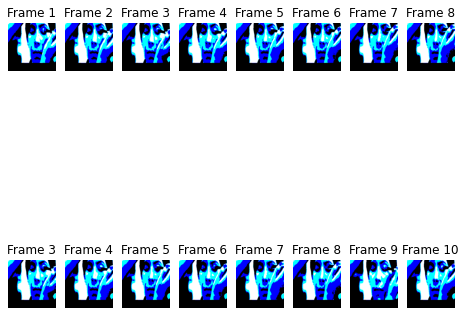

In [6]:
import matplotlib.pyplot as plt
sample, label = VideoDataset(dataset = dataset,split = 'train',preprocess = False)[30]

# 将图像的通道维度移到最后一个维度上
sample = sample.permute(1, 2, 3, 0)

# 可视化显示16帧图像
fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(8, 8))
for i in range(2):
    for j in range(8):
        idx = i * 2 + j
        axes[i][j].imshow(sample[idx].numpy())
        axes[i][j].axis('off')
        axes[i][j].set_title(f"Frame {idx+1}")
plt.show()

In [5]:
import os.path
import logging
import math
import shutil
import time
from collections import defaultdict

import torch
import os
import random
import torch.distributed as dist
from torch.autograd import Variable

def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True

def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()

def get_rank():
    if not is_dist_avail_and_initialized():
        return 0
    return dist.get_rank()    

def is_main_process():
    return get_rank() == 0


def makedirs(path):
    if not os.path.exists(path):
        os.makedirs(path, 0o777)

def load_value_file(file_path):
    with open(file_path, 'r') as input_file:
        value = float(input_file.read().rstrip('\n\r'))

    return value

def calculate_accuracy(outputs, targets):
    batch_size = targets.size(0)

    _, pred = outputs.topk(1, 1, True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1))
    n_correct_elems = correct.float().sum().item()

    return n_correct_elems / batch_size

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)
    
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.contiguous().t()
    correct = pred.eq(target.view(1, -1).expand_as(pred)).contiguous()

    res = []
    for k in topk:
        correct_k = correct[:k].contiguous().view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

def adjust_learning_rate1(optimizer, base_lr, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""

    alpha = (epoch + 2000) / 2000
    warm = (1. / 10) * (1 - alpha) + alpha
    lr = base_lr * warm
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr 

def adjust_learning_rate(optimizer, base_lr, epoch, lr_steps):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    decay = 0.1 ** (sum(epoch >= np.array(lr_steps)))
    lr = base_lr * decay
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def part_state_dict(state_dict, model_dict):
    pretrained_dict = {}
    for k, v in state_dict.items():
        if k in model_dict:
            pretrained_dict[k] = v
        else:
            print(k)
    pretrained_dict = inflate_state_dict(pretrained_dict, model_dict)
    #model_dict.update(pretrained_dict)
    return pretrained_dict

def inflate_state_dict(pretrained_dict, model_dict):
    for k in pretrained_dict.keys():
        if k in model_dict.keys() and 'fc' not in k:
            if pretrained_dict[k].size() != model_dict[k].size():
                assert(
                    pretrained_dict[k].size()[:2] == model_dict[k].size()[:2]), "To inflate, channel number should match."
                assert(pretrained_dict[k].size()[-2:] == model_dict[k].size()[-2:]), "To inflate, spatial kernel size should match."
                #print("Layer {} needs inflation.".format(k))
                shape = list(pretrained_dict[k].shape)
                shape.insert(2, 1)
                t_length = model_dict[k].shape[2]
                pretrained_dict[k] = pretrained_dict[k].reshape(shape)
                if t_length != 1:
                    pretrained_dict[k] = pretrained_dict[k].expand_as(
                        model_dict[k]) / t_length
                assert(pretrained_dict[k].size() == model_dict[k].size()), \
                    "After inflation, model shape should match."

    return pretrained_dict  

In [6]:
class AverageMeter(object):

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.sum],
                         dtype=torch.float64, device='cuda')
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.sum = t[1]
        self.avg = self.sum / (self.count + 1e-5)

In [7]:
class NL_block(nn.Module):
    def __init__(self,in_channels,reduction=2,use_scale=True):
        super(NL_block,self).__init__()
        self.in_channels=in_channels
        self.reduction=reduction
        self.use_scale=use_scale
        self.inter_channels=max(in_channels//reduction,1)#原文中inter_channels减半
        #使用embed高斯模式
        #定义g函数和输出函数
        self.g = nn.Conv3d(self.in_channels,self.inter_channels,kernel_size=1,)
        self.conv_out = nn.Conv3d(self.inter_channels,self.in_channels,kernel_size=1,)
        #定义theta和phi函数
        self.theta = nn.Conv3d(self.in_channels,self.inter_channels,kernel_size=1,)
        self.phi = nn.Conv3d(self.in_channels,self.inter_channels,kernel_size=1,)

    def embedded_gaussian(self,theta_x,phi_x):
        pairwise_weight = torch.matmul(theta_x,phi_x)
        if self.use_scale:
            pairwise_weight /= theta_x.shape[-1]**0.5       
        pairwise_weight /= pairwise_weight.softmax(dim=-1)
        return pairwise_weight

    def forward(self,x):
        n = x.size(0)
        g_x = self.g(x).view(n,self.inter_channels,-1)
        g_x = g_x.permute(0,2,1)
        
        theta_x = self.theta(x).view(n,self.inter_channels,-1)
        theta_x = theta_x.permute(0,2,1)
        phi_x = self.phi(x).view(n,self.inter_channels,-1)

        pairwise_weight = self.embedded_gaussian(theta_x,phi_x)
        y  = torch.matmul(pairwise_weight,g_x)
        out = y.permute(0, 2, 1).contiguous().reshape(n, self.inter_channels,*x.size()[2:])
        
        out = self.conv_out(out)
        return out

In [8]:
class TSElayer(nn.Module):
    reduction = 2
    def __init__(self,inplane):
        super(TSElayer,self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(nn.Linear(inplane,inplane // self.reduction,bias=False),
                                nn.ReLU(inplace=True),
                                nn.Linear(inplane // self.reduction,inplane,bias=False),
                                nn.Sigmoid())
        
        #初始化fc层的线性层参数
        for i in range(2):
            if i == 1:
                nn.init.constant(self.fc[i+1].weight,1)
                nn.init.constant(self.fc[i+1].bias,0)
            else:
                nn.init.constant(self.fc[i].weight,1)
                nn.init.constant(self.fc[i].bias,0)

    def forward(self,x):
        n,c,t,_,_ = x.size()
        x = x.transpose(1,2)#只交换维度，不改变数组
        x = x.view(n,t,c,-1)
        out = self.pool(x).view(n,t)
        out = self.fc(out).view(n,1,t,1,1)

        return out

In [9]:
class SElayer(nn.Module):
    reduction = 16
    def __init__(self,inplane):
        super(SElayer,self).__init__()
        self.pool = nn.AdaptiveAvgPool3d(1)
        self.fc = nn.Sequential(nn.Linear(inplane,inplane // self.reduction,bias=False),
                                nn.ReLU(inplace=True),
                                nn.Linear(inplane // self.reduction,inplane,bias=False),
                                nn.Sigmoid())

    def forward(self,x):
        n,c,_,_,_ = x.size()
        #x = x.transpose(1,2)#只交换维度，不改变数组
        y = self.pool(x).view(n,c)
        #out = self.pool(x).view(n,t)
        out = self.fc(y).view(n,c,1,1,1)

        return x * out.expand_as(x)

In [10]:
class NLC_block(nn.Module):
    def __init__(self,in_channels,reduction=16):
        super(NLC_block,self).__init__()
        #self.big = nn.MaxPool3d(kernel_size=3,padding=1,stride=1)
        #self.bn1 = nn.BatchNorm3d(in_channels)
        self.in_channels=in_channels
        self.reduction=reduction
        #self.use_scale=use_scale
        self.avg = nn.AdaptiveAvgPool3d((None,1,1))
        self.bn2 = nn.BatchNorm1d(in_channels)
        self.inter_channels=max(in_channels//reduction,1)#原文中inter_channels减半
        #使用embed高斯模式
        #定义g函数和输出函数
        #self.g = nn.Conv3d(self.in_channels,self.inter_channels,kernel_size=1,)
        #self.conv_out = nn.Conv3d(self.inter_channels,self.in_channels,kernel_size=1,)
        self.g = nn.Conv1d(self.in_channels,self.inter_channels,kernel_size=3,padding=1,groups=self.inter_channels)
        self.conv_out = nn.Conv1d(self.inter_channels,self.in_channels,kernel_size=3,padding=1,groups=self.inter_channels)
        #定义theta和phi函数
        #self.theta = nn.Conv3d(self.in_channels,self.inter_channels,kernel_size=1,)
        #self.phi = nn.Conv3d(self.in_channels,self.inter_channels,kernel_size=1,)
        self.theta = nn.Conv1d(self.in_channels,self.inter_channels,kernel_size=3,padding=1,groups=self.inter_channels)
        self.phi = nn.Conv1d(self.in_channels,self.inter_channels,kernel_size=3,padding=1,groups=self.inter_channels)
        self.sigmoid = nn.Sigmoid()

    def embedded_gaussian(self,theta_x,phi_x):
        pairwise_weight = torch.matmul(theta_x,phi_x)
        #if self.use_scale:
            #pairwise_weight /= theta_x.shape[-1]**0.5       
        #pairwise_weight /= pairwise_weight.softmax(dim=-1)
        pairwise_weight = F.softmax(pairwise_weight,dim=-1)

        return pairwise_weight

    def forward(self,x):
        n,b,t,_,_ = x.size()
        #resduial = x
        #x = self.big(x)
        #x = self.bn1(x)
        x = self.avg(x)
        x = x.view(n,self.in_channels,-1)
        x = self.bn2(x)
        g_x = self.g(x)
        g_x = g_x.permute(0,2,1)
        
        theta_x = self.theta(x)
        theta_x = theta_x.permute(0,2,1)
        phi_x = self.phi(x)

        pairwise_weight = self.embedded_gaussian(theta_x,phi_x)
        y  = torch.matmul(pairwise_weight,g_x)
        y = y.permute(0,2,1)
        
        out = self.conv_out(y)
        out = out.reshape(n,b,t,1,1)
        out = self.sigmoid(out)        
        return out

In [152]:
class GTC_block(nn.Module):
    def __init__(self,in_channels,reduction=2):
        super(GTC_block,self).__init__()
        #self.big = nn.MaxPool3d(kernel_size=3,padding=1,stride=1)
        #self.bn1 = nn.BatchNorm3d(in_channels)
        self.in_channels=in_channels
        #self.num_segment = num_segment
        self.reduction=reduction
        #self.use_scale=use_scale
        self.avg = nn.AdaptiveAvgPool3d((None,1,1))
        self.bn1 = nn.BatchNorm1d(in_channels)
        #self.bn2 = nn.BatchNorm1d(in_channels)
        self.inter_channels=max(in_channels//reduction,1)#原文中inter_channels减半
        #使用embed高斯模式
        #定义g函数和输出函数
        #self.g = nn.Conv3d(self.in_channels,self.inter_channels,kernel_size=1,)
        #self.conv_out = nn.Conv3d(self.inter_channels,self.in_channels,kernel_size=1,)
        self.g = nn.Conv1d(self.in_channels,self.in_channels,kernel_size=3,padding=1,groups=self.in_channels)
        #self.conv_out = nn.Conv1d(self.inter_channels,self.in_channels,kernel_size=1,padding=0,groups=1)
        #定义theta和phi函数
        #self.theta = nn.Conv3d(self.in_channels,self.inter_channels,kernel_size=1,)
        #self.phi = nn.Conv3d(self.in_channels,self.inter_channels,kernel_size=1,)
        self.theta = nn.Conv1d(self.in_channels,self.in_channels,kernel_size=3,padding = 1,groups=self.in_channels)
        self.phi = nn.Conv1d(self.in_channels,self.in_channels,kernel_size=3,padding = 1,groups=self.in_channels)
        
        ## init seprabale conv as init
        self.g.weight.data.zero_()
        self.g.weight[:, :, 3 // 2].data.fill_(1)
        ## init seprabale conv as init
        self.theta.weight.data.zero_()
        self.theta.weight[:, :, 3 // 2].data.fill_(1)
        ## init seprabale conv as init
        self.phi.weight.data.zero_()
        self.phi.weight[:, :, 3 // 2].data.fill_(1)
        #self.sigmoid = nn.Sigmoid()

        for m in self.modules():
            if isinstance(m, nn.Conv3d) or isinstance(m, nn.Conv1d):
                if m.bias is not None:
                    m.bias.data.zero_()
            if isinstance(m, nn.BatchNorm3d) or isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
        
    def embedded_gaussian(self,theta_x,phi_x):
        pairwise_weight = torch.matmul(theta_x,phi_x)
        #if self.use_scale:
            #pairwise_weight /= theta_x.shape[-1]**0.5       
        #pairwise_weight /= pairwise_weight.softmax(dim=-1)
        pairwise_weight = F.softmax(pairwise_weight,dim=-1)

        return pairwise_weight

    def forward(self,x):
        n,c,t,h,w = x.size()
        #n = nt // self.num_segment
        resduial = x
        #x = self.big(x)
        #x = self.bn1(x)
        #时间通道注意力分支
        x = self.avg(x)
        #x = x.view((-1,self.num_segment)+(x.size()[1:]))#n,t,c,1,1
        x = x.contiguous().view(n,c,-1)#合并为通道维度
        #x = x.permute(0,2,1)#shape:n,c,t
        x = self.bn1(x)#按照通道进行批归一化
        #g_x = self.g(x)
        #g_x = g_x.permute(0,2,1)#交换两个维度
        
        theta_x = self.theta(x).permute(0,2,1)#n,t,c
        phi_x = self.phi(x)
            
        pairwise_weight = self.embedded_gaussian(theta_x,phi_x)#通道自注意力分数(shape:t*t)
        #1d卷积分支
        new_r = resduial.permute(0,3,4,1,2)#n,h,w,c,t
        new_r = resduial.view(-1,c,t)#nhw,c,t
        new_r = self.g(new_r)
        new_r = new_r.reshape(n,c*h*w,t)#n,chw,t
        #new_r = new_r.permute(0,2,1)
        new_r = torch.matmul(new_r,pairwise_weight)#n,chw,t
        new_r = new_r.reshape(n,c,t,h,w)#n,t,c,h,w
        #new_r = new_r.permute(0,4,1,2,3)
        #new_r = new_r.contiguous().view((-1,) + new_r.size()[2:])
        x_out = resduial + new_r
        
        return x_out

In [153]:
class NLC5_block(nn.Module):
    def __init__(self,in_channels,reduction=16):
        super(NLC5_block,self).__init__()
        #self.big = nn.MaxPool3d(kernel_size=3,padding=1,stride=1)
        #self.bn1 = nn.BatchNorm3d(in_channels)
        self.in_channels=in_channels
        self.reduction=reduction
        #self.use_scale=use_scale
        self.avg = nn.AdaptiveAvgPool3d((None,1,1))
        self.bn2 = nn.BatchNorm1d(in_channels)
        self.inter_channels=max(in_channels//reduction,1)#原文中inter_channels减半
        #使用embed高斯模式
        #定义g函数和输出函数
        #self.g = nn.Conv3d(self.in_channels,self.inter_channels,kernel_size=1,)
        #self.conv_out = nn.Conv3d(self.inter_channels,self.in_channels,kernel_size=1,)
        self.g = nn.Conv1d(self.in_channels,self.inter_channels,kernel_size=5,padding=2,groups=self.inter_channels)
        self.conv_out = nn.Conv1d(self.inter_channels,self.in_channels,kernel_size=5,padding=2,groups=self.inter_channels)
        #定义theta和phi函数
        #self.theta = nn.Conv3d(self.in_channels,self.inter_channels,kernel_size=1,)
        #self.phi = nn.Conv3d(self.in_channels,self.inter_channels,kernel_size=1,)
        self.theta = nn.Conv1d(self.in_channels,self.inter_channels,kernel_size=5,padding=2,groups=self.inter_channels)
        self.phi = nn.Conv1d(self.in_channels,self.inter_channels,kernel_size=5,padding=2,groups=self.inter_channels)
        self.sigmoid = nn.Sigmoid()

    def embedded_gaussian(self,theta_x,phi_x):
        pairwise_weight = torch.matmul(theta_x,phi_x)
        #if self.use_scale:
            #pairwise_weight /= theta_x.shape[-1]**0.5       
        #pairwise_weight /= pairwise_weight.softmax(dim=-1)
        pairwise_weight = F.softmax(pairwise_weight,dim=-1)

        return pairwise_weight

    def forward(self,x):
        n,b,t,_,_ = x.size()
        #resduial = x
        #x = self.big(x)
        #x = self.bn1(x)
        x = self.avg(x)
        x = x.view(n,self.in_channels,-1)
        x = self.bn2(x)
        g_x = self.g(x)
        g_x = g_x.permute(0,2,1)
        
        theta_x = self.theta(x)
        theta_x = theta_x.permute(0,2,1)
        phi_x = self.phi(x)

        pairwise_weight = self.embedded_gaussian(theta_x,phi_x)
        y  = torch.matmul(pairwise_weight,g_x)
        y = y.permute(0,2,1)
        
        out = self.conv_out(y)
        out = out.reshape(n,b,t,1,1)
        out = self.sigmoid(out)        
        return out

In [154]:
class NLC7_block(nn.Module):
    def __init__(self,in_channels,reduction=16):
        super(NLC7_block,self).__init__()
        #self.big = nn.MaxPool3d(kernel_size=3,padding=1,stride=1)
        #self.bn1 = nn.BatchNorm3d(in_channels)
        self.in_channels=in_channels
        self.reduction=reduction
        #self.use_scale=use_scale
        self.avg = nn.AdaptiveAvgPool3d((None,1,1))
        self.bn2 = nn.BatchNorm1d(in_channels)
        self.inter_channels=max(in_channels//reduction,1)#原文中inter_channels减半
        #使用embed高斯模式
        #定义g函数和输出函数
        #self.g = nn.Conv3d(self.in_channels,self.inter_channels,kernel_size=1,)
        #self.conv_out = nn.Conv3d(self.inter_channels,self.in_channels,kernel_size=1,)
        self.g = nn.Conv1d(self.in_channels,self.inter_channels,kernel_size=7,padding=3,groups=self.inter_channels)
        self.conv_out = nn.Conv1d(self.inter_channels,self.in_channels,kernel_size=7,padding=3,groups=self.inter_channels)
        #定义theta和phi函数
        #self.theta = nn.Conv3d(self.in_channels,self.inter_channels,kernel_size=1,)
        #self.phi = nn.Conv3d(self.in_channels,self.inter_channels,kernel_size=1,)
        self.theta = nn.Conv1d(self.in_channels,self.inter_channels,kernel_size=7,padding=3,groups=self.inter_channels)
        self.phi = nn.Conv1d(self.in_channels,self.inter_channels,kernel_size=7,padding=3,groups=self.inter_channels)
        self.sigmoid = nn.Sigmoid()

    def embedded_gaussian(self,theta_x,phi_x):
        pairwise_weight = torch.matmul(theta_x,phi_x)
        #if self.use_scale:
            #pairwise_weight /= theta_x.shape[-1]**0.5       
        #pairwise_weight /= pairwise_weight.softmax(dim=-1)
        pairwise_weight = F.softmax(pairwise_weight,dim=-1)

        return pairwise_weight

    def forward(self,x):
        n,b,t,_,_ = x.size()
        #resduial = x
        #x = self.big(x)
        #x = self.bn1(x)
        x = self.avg(x)
        x = x.view(n,self.in_channels,-1)
        x = self.bn2(x)
        g_x = self.g(x)
        g_x = g_x.permute(0,2,1)
        
        theta_x = self.theta(x)
        theta_x = theta_x.permute(0,2,1)
        phi_x = self.phi(x)

        pairwise_weight = self.embedded_gaussian(theta_x,phi_x)
        y  = torch.matmul(pairwise_weight,g_x)
        y = y.permute(0,2,1)
        
        out = self.conv_out(y)
        out = out.reshape(n,b,t,1,1)
        out = self.sigmoid(out)        
        return out

In [155]:
class Bottleneck2D(nn.Module):
    expansion = 4
    def __init__(self,inplanes,planes,stride = 1,t_stride = 1,downsample = None,t_length = None):
        super(Bottleneck2D,self).__init__()
        self.conv1 = nn.Conv3d(inplanes,planes,kernel_size=1,stride=[t_stride,1,1],bias=False)
        self.bn1 = nn.BatchNorm3d(planes)
        self.conv2 = nn.Conv3d(planes,planes,kernel_size=(1,3,3),stride=[1,stride,stride],padding=(0,1,1),bias=False)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv3 = nn.Conv3d(planes,planes*self.expansion,kernel_size=1,bias=False)
        self.bn3 = nn.BatchNorm3d(planes*self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self,x):
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)

        return out

In [156]:
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self,inplanes,planes,stride = 1,t_stride = 1,downsample = None,t_length = None):
        super(Bottleneck,self).__init__()
        self.conv1 = nn.Conv2d(inplanes,planes,kernel_size=1,stride=1,bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes,planes,kernel_size=3,stride=stride,padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes,planes*self.expansion,kernel_size=1,bias=False)
        self.bn3 = nn.BatchNorm2d(planes*self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self,x):
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)

        return out

In [157]:
#加入nlc块的res块
class Bottleneck_NLC(nn.Module):
    expansion = 4
    def __init__(self,inplanes,planes,stride = 1,t_stride = 1,downsample = None,t_length = None):
        super(Bottleneck_NLC,self).__init__()
        self.nlc = NLC_block(inplanes)
        self.conv1 = nn.Conv3d(inplanes,planes,kernel_size=1,stride=[t_stride,1,1],bias=False)
        self.bn1 = nn.BatchNorm3d(planes)
        self.conv2 = nn.Conv3d(planes,planes,kernel_size=(1,3,3),stride=(1,stride,stride),padding=(0,1,1),bias=False)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv3 = nn.Conv3d(planes,planes*self.expansion,kernel_size=1,bias=False)
        self.bn3 = nn.BatchNorm3d(planes*self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self,x):
        residual = x
        x = x * self.nlc(x)
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)

        return out

In [160]:
#加入nlc块的res块
class Bottleneck_GTC(nn.Module):
    expansion = 4
    def __init__(self,inplanes,planes,stride = 1,t_stride = 1,downsample = None,t_length = None):
        super(Bottleneck_GTC,self).__init__()
        self.gtc = GTC_block(inplanes)
        self.conv1 = nn.Conv3d(inplanes,planes,kernel_size=1,stride=[t_stride,1,1],bias=False)
        self.bn1 = nn.BatchNorm3d(planes)
        self.conv2 = nn.Conv3d(planes,planes,kernel_size=(1,3,3),stride=(1,stride,stride),padding=(0,1,1),bias=False)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv3 = nn.Conv3d(planes,planes*self.expansion,kernel_size=1,bias=False)
        self.bn3 = nn.BatchNorm3d(planes*self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self,x):
        residual = x
        x = self.gtc(x)
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)

        return out

In [161]:
class BottleneckSE(nn.Module):
    expansion = 4
    def __init__(self,inplanes,planes,stride = 1,t_stride = 1,downsample = None,t_length = None):
        super(BottleneckSE,self).__init__()
        self.se = SElayer(inplane=inplanes)
        self.conv1 = nn.Conv3d(inplanes,planes,kernel_size=1,stride=[t_stride,1,1],bias=False)
        self.bn1 = nn.BatchNorm3d(planes)
        self.conv2 = nn.Conv3d(planes,planes,kernel_size=(1,3,3),stride=[1,stride,stride],padding=(0,1,1),bias=False)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv3 = nn.Conv3d(planes,planes*self.expansion,kernel_size=1,bias=False)
        self.bn3 = nn.BatchNorm3d(planes*self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self,x):
        residual = x
        x = self.se(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)

        return out

In [162]:
#加入nlc块的res块
class Bottleneck_NLC5(nn.Module):
    expansion = 4
    def __init__(self,inplanes,planes,stride = 1,t_stride = 1,downsample = None,t_length = None):
        super(Bottleneck_NLC5,self).__init__()
        self.nlc = NLC5_block(inplanes)
        self.conv1 = nn.Conv3d(inplanes,planes,kernel_size=1,stride=[t_stride,1,1],bias=False)
        self.bn1 = nn.BatchNorm3d(planes)
        self.conv2 = nn.Conv3d(planes,planes,kernel_size=(1,3,3),stride=(1,stride,stride),padding=(0,1,1),bias=False)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv3 = nn.Conv3d(planes,planes*self.expansion,kernel_size=1,bias=False)
        self.bn3 = nn.BatchNorm3d(planes*self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self,x):
        residual = x
        x = x * self.nlc(x)
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)

        return out

In [163]:
#加入nlc7块的res块
class Bottleneck_NLC7(nn.Module):
    expansion = 4
    def __init__(self,inplanes,planes,stride = 1,t_stride = 1,downsample = None,t_length = None):
        super(Bottleneck_NLC7,self).__init__()
        self.nlc = NLC7_block(inplanes)
        self.conv1 = nn.Conv3d(inplanes,planes,kernel_size=1,stride=[t_stride,1,1],bias=False)
        self.bn1 = nn.BatchNorm3d(planes)
        self.conv2 = nn.Conv3d(planes,planes,kernel_size=(1,3,3),stride=(1,stride,stride),padding=(0,1,1),bias=False)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv3 = nn.Conv3d(planes,planes*self.expansion,kernel_size=1,bias=False)
        self.bn3 = nn.BatchNorm3d(planes*self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self,x):
        residual = x
        x = x * self.nlc(x)
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)

        return out

In [164]:
class Bottleneck_T(nn.Module):
    expansion = 4
    def __init__(self,inplanes,planes,stride = 1,t_stride = 1,downsample = None,t_length = None):
        super(Bottleneck_T,self).__init__()
        self.conv1 = nn.Conv3d(inplanes,planes,kernel_size=1,bias=False)
        self.bn1 = nn.BatchNorm3d(planes)
        self.big1 = nn.MaxPool3d(kernel_size=3,padding=1,stride=1)
        self.tse1 = TSElayer(16)#16帧
        self.conv2 = nn.Conv3d(planes,planes,kernel_size=(1,3,3),stride=(1,stride,stride),padding=(0,1,1),bias=False)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv3 = nn.Conv3d(planes,planes*self.expansion,kernel_size=1,bias=False)
        self.bn3 = nn.BatchNorm3d(planes*self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self,x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out1 = out + out * self.tse1(self.big1(out))

        out2 = self.conv2(out1)
        out2 = self.bn2(out2)
        out2 = self.relu(out2)
        
        out3 = self.conv3(out2)
        out3 = self.bn3(out3)
        
        if self.downsample is not None:
            residual = self.downsample(x)
        
        out3 += residual
        out3 = self.relu(out3)

        return out3

In [165]:
#使用3D卷积，并且只对空间进行提取最大视图
class Bottleneck100_T1(nn.Module):
    expansion = 4
    def __init__(self,inplanes,planes,stride = 1,t_stride = 1,downsample = None,t_length = None):
        super(Bottleneck_T,self).__init__()
        self.conv1 = nn.Conv3d(inplanes,planes,kernel_size=1,bias=False)
        self.bn1 = nn.BatchNorm3d(planes)
        self.big1 = nn.MaxPool3d(kernel_size = (1,3,3),padding = (0,1,1),stride=1)
        self.tse1 = TSElayer(16)
        self.conv2 = nn.Conv3d(planes,planes,kernel_size=3,stride=stride,padding=1,bias=False)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv3 = nn.Conv3d(planes,planes*self.expansion,kernel_size=1,bias=False)
        self.bn3 = nn.BatchNorm3d(planes*self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self,x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out1 = out + self.tse1(self.big1(out))

        out2 = self.conv2(out1)
        out2 = self.bn2(out2)
        out2 = self.relu(out2)
        
        out3 = self.conv3(out2)
        out3 = self.bn3(out3)
        if self.downsample is not None:
            residual = self.downsample(x)
        
        out3 += residual
        out3 = self.relu(out3)

        return out3

In [166]:
class local_NolocalNet(nn.Module):
    def __init__(self,Test,block,layers,imagenet_pre,num_channels,num_classes=1000,feat=False,t_length=8,**kwargs):
        if not isinstance(block,list):
            block = [block]*4
        self.inplanes = 64
        super(local_NolocalNet,self).__init__()

        self.feat = feat
        self.conv1 = nn.Conv3d(3,64,kernel_size=(1,7,7),stride=[1,2,2],padding=(0,3,3),bias=False)
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool3d(kernel_size=3,stride=2,padding=1)
        self.layer1 = self._make_layer(block[0],num_channels[0],layers[0])
        #self.NL1 = nn.Sequential(nn.MaxPool3d(kernel_size = 3,padding = 1,stride=1),
                                #nn.BatchNorm3d(num_channels[0]*4),
                                #NL_block(num_channels[0]*4))    
        self.layer2 = self._make_layer(block[1],num_channels[1],layers[1],stride=2,t_stride=1,t_length=t_length)
        #self.NL2 = nn.Sequential(nn.MaxPool3d(kernel_size = 3,padding = 1,stride=[2,1,1]),
                                #nn.BatchNorm3d(num_channels[1]*4),
                                #NL_block(num_channels[1]*4))  
        self.layer3 = self._make_layer(block[2],num_channels[2],layers[2],stride=2,t_stride=1,t_length=t_length)
        #self.NL3 = nn.Sequential(nn.MaxPool3d(kernel_size = 3,padding = 1,stride=1),
                                #nn.BatchNorm3d(num_channels[2]*4),
                                #NL_block(num_channels[2]*4))  
        self.layer4 = self._make_layer(block[3],num_channels[3],layers[3],stride = 2,t_stride = 1,t_length=t_length)
        #self.NL4 = nn.Sequential(nn.MaxPool3d(kernel_size = 3,padding = 1,stride=1),
                                #nn.BatchNorm3d(num_channels[3]*4),
                                #NL_block(num_channels[3]*4))  
        self.avgpool = nn.AdaptiveAvgPool3d(1)

        self.feat_dim = 512 * block[0].expansion
        self.test = Test
        if imagenet_pre and is_main_process():
            print('using imagenet pretraining weight set the BN as zero')

        if not feat:
            self.fc = nn.Linear(self.feat_dim,num_classes)
            
        for n,m in self.named_modules():
            if isinstance(m,nn.Conv3d):
                nn.init.kaiming_normal_(m.weight,mode='fan_out',nonlinearity='relu')#kaiming初始化
            if 'big' in n:
                if isinstance(m,nn.BatchNorm3d):
                    nn.init.constant_(m.weight,0)
                    nn.init.constant_(m.bias,0)        

    def _make_layer(self,block,planes,blocks,stride=1,t_stride=1,t_length=8):
        downsample = None
        #步长为1，视频帧大小不会发生变化
        if stride != 1 or self.inplanes != planes*block.expansion:
            downsample = nn.Sequential(nn.Conv3d(self.inplanes,planes*block.expansion,kernel_size=1,stride=(1,stride,stride),bias=False),
                                    nn.BatchNorm3d(planes*block.expansion),)
        layers = []
        layers.append(block(self.inplanes,planes,stride=stride,t_stride=t_stride,downsample=downsample,t_length=t_length))
        self.inplanes = planes * block.expansion

        for i in range(1,blocks):
            layers.append(block(self.inplanes,planes,t_length=t_length))

        return nn.Sequential(*layers)

    def forward(self,x):
        out = self.maxpool1(self.relu(self.bn1(self.conv1(x))))

        out = self.layer1(out)
        #out = self.NL1(out)
        out = self.layer2(out)
        #out = self.NL2(out)
        out = self.layer3(out)
        #out = self.NL3(out)
        out = self.layer4(out)
        #out = self.NL4(out)

        out = self.avgpool(out)
        if not self.test:
            out = out.view(out.size(0),-1)#按列展开
        if not self.feat:
            out = self.fc(out)
            
        return out 

In [167]:

class TseBigNet(nn.Module):
    def __init__(self,Test,block,layers,imagenet_pre,num_classes=1000,feat=False,t_length=8,**kwargs):
        if not isinstance(block,list):
            block = [block]*4
        self.inplanes = 64
        super(TseBigNet,self).__init__()

        self.feat = feat
        self.conv1 = nn.Conv3d(3,64,kernel_size=(1,7,7),stride=[1,2,2],padding=(0,3,3),bias=False)
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=(1,3,3),stride=[1,2,2],padding=(0,1,1))
        self.layer1 = self._make_layer(block[0],64,layers[0])    
        self.layer2 = self._make_layer(block[1],128,layers[1],stride=2,t_stride=1,t_length=t_length)
        self.layer3 = self._make_layer(block[2],256,layers[2],stride=2,t_stride=1,t_length=t_length)
        self.layer4 = self._make_layer(block[3],512,layers[3],stride = 2,t_stride = 1,t_length=t_length)
        self.avgpool = nn.AdaptiveAvgPool3d(1)

        self.feat_dim = 512 * block[0].expansion
        self.test = Test
        if imagenet_pre and is_main_process():
            print('using imagenet pretraining weight set the BN as zero')

        if not feat:
            self.fc = nn.Linear(self.feat_dim,num_classes)
        
        #初始化权重
        for n,m in self.named_modules():
            if isinstance(m,nn.Conv3d):
                nn.init.kaiming_normal_(m.weight,mode='fan_out',nonlinearity='relu')
            elif isinstance(m,nn.BatchNorm3d):
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)

    def _make_layer(self,block,planes,blocks,stride=1,t_stride=1,t_length=8):
        downsample = None
        #步长为1，视频帧大小不会发生变化
        if stride != 1 or self.inplanes != planes*block.expansion:
            downsample = nn.Sequential(nn.Conv3d(self.inplanes,planes*block.expansion,kernel_size=1,stride=(1,stride,stride),bias=False),
                                    nn.BatchNorm3d(planes*block.expansion),)
        layers = []
        layers.append(block(self.inplanes,planes,stride=stride,t_stride=t_stride,downsample=downsample,t_length=t_length))
        self.inplanes = planes * block.expansion

        for i in range(1,blocks):
            layers.append(block(self.inplanes,planes,t_length=t_length))

        return nn.Sequential(*layers)

    def forward(self,x):
        out = self.maxpool(self.relu(self.bn1(self.conv1(x))))

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        if not self.test:
            out = out.view(out.size(0),-1)#按列展开
        if not self.feat:
            out = self.fc(out)
            
        return out

In [168]:
class NLCNet(nn.Module):
    def __init__(self,Test,block,layers,imagenet_pre,num_classes=1000,feat=False,t_length=8,**kwargs):
        if not isinstance(block, list):
            block = [block] * 4
        self.inplanes = 64
        super(NLCNet, self).__init__()

        #self.nlc = NLC_block()

        self.feat = feat
        self.conv1 = nn.Conv3d(3, 64, kernel_size=(1, 7, 7),stride=(1, 2, 2), padding=(0, 3, 3),bias=False)
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1))
        self.layer1 = self._make_layer(block[0], 64, layers[0])
        self.layer2 = self._make_layer(block[1],128,layers[1],stride=2,t_stride=1, t_length=t_length)
        self.layer3 = self._make_layer(block[2],256,layers[2],stride=2,t_stride=1,t_length=t_length)
        self.layer4 = self._make_layer(block[3],512,layers[3],stride=2,t_stride=1,t_length=t_length)
        self.avgpool = nn.AdaptiveAvgPool3d(1)

        self.feat_dim = 512 * block[0].expansion
        self.test = Test
        if imagenet_pre and is_main_process():
            print('using imagenet pretraining weight set the BN as zero')

        if not feat:
            self.fc = nn.Linear(self.feat_dim, num_classes)
        
        #初始化参数
        for n, m in self.named_modules():
            if isinstance(m, nn.Conv3d) or isinstance(m,nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if isinstance(m,nn.BatchNorm3d) or isinstance(m,nn.BatchNorm1d):
                nn.init.constant_(m.weight,0)
                nn.init.constant_(m.bias,0)
            #if 'big' in n:
                #if isinstance(m, nn.BatchNorm3d):
                    #nn.init.constant_(m.weight, 0)
                    #nn.init.constant_(m.bias, 0)

    def _make_layer(self,block,planes,blocks,stride=1,t_stride=1,t_length=8):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv3d(
                    self.inplanes,planes * block.expansion,kernel_size=1,stride=(1, stride, stride),bias=False),
                nn.BatchNorm3d(planes * block.expansion),
            )
        layers = []
        layers.append(
            block(
                self.inplanes,planes,stride=stride,t_stride=t_stride,downsample=downsample,t_length=t_length))
        self.inplanes = planes * block.expansion

        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, t_length=t_length))

        return nn.Sequential(*layers)
    
    
    def _make_full_layer(self,block,planes,blocks,stride=1,t_stride=1,t_length=8):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv3d(
                    self.inplanes,planes * block.expansion,kernel_size=1,stride=(1, stride, stride),bias=False),
                nn.BatchNorm3d(planes * block.expansion),
            )
        layers = []
        layers.append(NLC_block(self.inplanes,reduction = 16))
        layers.append(
            block(
                self.inplanes,planes,stride=stride,t_stride=t_stride,downsample=downsample,t_length=t_length))
        self.inplanes = planes * block.expansion

        for i in range(1, blocks):
            layers.append(NLC_block(self.inplanes,reduction = 16))
            layers.append(block(self.inplanes, planes, t_length=t_length))

        return nn.Sequential(*layers)
    
    
    def _make_last_layer(self,block,planes,blocks,stride=1,t_stride=1,t_length=8):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv3d(
                    self.inplanes,planes * block.expansion,kernel_size=1,stride=(1, stride, stride),bias=False),
                nn.BatchNorm3d(planes * block.expansion),
            )
        layers = []
        layers.append(
            block(
                self.inplanes,planes,stride=stride,t_stride=t_stride,downsample=downsample,t_length=t_length))
        self.inplanes = planes * block.expansion
        
        for i in range(1, blocks):
            if i != blocks-1:
                layers.append(block(self.inplanes,planes,t_length=t_length))
            else:
                layers.append(NLC_block(self.inplanes,reduction = 16))
                layers.append(block(self.inplanes,planes,t_length=t_length))    

        return nn.Sequential(*layers)

    def forward(self, input):
        x = self.conv1(input)
        x = self.bn1(x)

        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        if not self.test:
            x = x.view(x.size(0), -1)
        if not self.feat:
            x = self.fc(x)
        return x

In [297]:
class ResNet(nn.Module):
    def __init__(self,Test,block,layers,imagenet_pre,num_classes=1000,feat=False,t_length=8,**kwargs):
        if not isinstance(block,list):
            block = [block]*4
        self.inplanes = 64
        super(ResNet,self).__init__()

        self.feat = feat
        self.num_segment = t_length
        self.conv1 = nn.Conv3d(3,64,kernel_size=(1,7,7),stride=[1,2,2],padding=(0,3,3),bias=False)
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=(1,3,3),stride=[1,2,2],padding=(0,1,1))#这层无需参数
        self.layer1 = self._make_layer(block[0],64,layers[0])    
        self.layer2 = self._make_layer(block[1],128,layers[1],stride=2,t_stride=1,t_length=t_length)
        self.layer3 = self._make_layer(block[2],256,layers[2],stride=2,t_stride=1,t_length=t_length)
        self.layer4 = self._make_layer(block[3],512,layers[3],stride = 2,t_stride = 1,t_length=t_length)
        self.avgpool = nn.AdaptiveAvgPool3d(1)

        self.feat_dim = 512 * block[0].expansion
        self.test = Test
        if imagenet_pre and is_main_process():
            print('using imagenet pretraining weight set the BN as zero')

        if not feat:
            self.fc = nn.Linear(self.feat_dim,num_classes)
        
        #参数初始化
        for n,m in self.named_modules():
            if isinstance(m,nn.Conv3d):
                nn.init.kaiming_normal_(m.weight,mode='fan_out',nonlinearity='relu')#kaiming初始化 
            elif isinstance(m,nn.BatchNorm3d):
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)
                
    def _make_layer(self,block,planes,blocks,stride=1,t_stride=1,t_length=8):
        downsample = None
        #步长为1，视频帧大小不会发生变化
        if stride != 1 or self.inplanes != planes*block.expansion:
            downsample = nn.Sequential(nn.Conv3d(self.inplanes,planes*block.expansion,kernel_size=1,stride=(1,stride,stride),bias=False),
                                    nn.BatchNorm3d(planes*block.expansion),)
        layers = []
        layers.append(block(self.inplanes,planes,stride=stride,t_stride=t_stride,downsample=downsample,t_length=t_length))
        self.inplanes = planes * block.expansion

        for i in range(1,blocks):
            layers.append(block(self.inplanes,planes,t_length=t_length))
        return nn.Sequential(*layers)

    def forward(self,x):
        x = x.view((-1, 3) + x.size()[-2:])#nt,c,h,w
        nt,c,h,w = x.size()
        x = x.reshape(x.size()[0]//self.num_segment,c,self.num_segment,h,w)#n,c,t,h,w
        
        out = self.maxpool(self.relu(self.bn1(self.conv1(x))))

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        if not self.test:
            out = out.view(out.size(0),-1)#按列展开
        if not self.feat:
            out = self.fc(out)
            
        return out

In [298]:
class ResNet2D(nn.Module):
    def __init__(self,Test,block,layers,imagenet_pre,num_classes=1000,feat=False,t_length=8,**kwargs):
        if not isinstance(block,list):
            block = [block]*4
        self.inplanes = 64
        super(ResNet2D,self).__init__()
            
        self.feat = feat
        self.num_segment = t_length
        self.conv1 = nn.Conv3d(3,64,kernel_size=7,stride=2,padding=3,bias=False)
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=3,stride=2,padding=1)#这层无需参数
        self.layer1 = self._make_layer(block[0],64,layers[0])    
        self.layer2 = self._make_layer(block[1],128,layers[1],stride=2,t_stride=1,t_length=t_length)
        self.layer3 = self._make_layer(block[2],256,layers[2],stride=2,t_stride=1,t_length=t_length)
        self.layer4 = self._make_layer(block[3],512,layers[3],stride = 2,t_stride = 1,t_length=t_length)
        self.avgpool = nn.AdaptiveAvgPool3d(1)

        self.feat_dim = 512 * block[0].expansion
        self.test = Test
        if imagenet_pre and is_main_process():
            print('using imagenet pretraining weight set the BN as zero')

        if not feat:
            self.fc = nn.Linear(self.feat_dim,num_classes)
        
        #参数初始化
        for n,m in self.named_modules():
            if isinstance(m,nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,mode='fan_out',nonlinearity='relu')#kaiming初始化 
            elif isinstance(m,nn.BatchNorm2d):
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)
                
    def _make_layer(self,block,planes,blocks,stride=1,t_stride=1,t_length=8):
        downsample = None
        #步长为1，视频帧大小不会发生变化
        if stride != 1 or self.inplanes != planes*block.expansion:
            downsample = nn.Sequential(nn.Conv2d(self.inplanes,planes*block.expansion,kernel_size=1,stride=stride,bias=False),
                                    nn.BatchNorm2d(planes*block.expansion),)
        layers = []
        layers.append(block(self.inplanes,planes,stride=stride,t_stride=t_stride,downsample=downsample,t_length=t_length))
        self.inplanes = planes * block.expansion

        for i in range(1,blocks):
            layers.append(block(self.inplanes,planes,t_length=t_length))
        return nn.Sequential(*layers)

    def forward(self,x):
        b,c,t,h,w = x.size()
        x = x.permute(0,2,1,3,4)
        x = x.reshape(-1,c,h,w)
        out = self.maxpool(self.relu(self.bn1(self.conv1(x))))

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.reshape(b,t,out.shape[1],out.shape[2],out.shape[3])
        out = out.permute(0,2,1,3,4)

        out = self.avgpool(out)
        if not self.test:
            out = out.view(out.size(0),-1)#按列展开
        if not self.feat:
            out = self.fc(out)
            
        return out

In [299]:
class ResNet2D_1(nn.Module):
    def __init__(self,Test,block,layers,imagenet_pre,num_classes=1000,feat=False,t_length=8,**kwargs):
        if not isinstance(block,list):
            block = [block]*4
        self.inplanes = 64
        super(ResNet2D_1,self).__init__()

        self.feat = feat
        self.num_segment = t_length
        self.conv1 = nn.Conv3d(3,64,kernel_size=(1,7,7),stride=[1,2,2],padding=(0,3,3),bias=False)
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=(1,3,3),stride=[1,2,2],padding=(0,1,1))#这层无需参数
        self.layer1 = self._make_layer(block[0],64,layers[0])    
        self.layer2 = self._make_layer(block[1],128,layers[1],stride=2,t_stride=1,t_length=t_length)
        self.layer3 = self._make_layer(block[2],256,layers[2],stride=2,t_stride=1,t_length=t_length)
        self.layer4 = self._make_layer(block[3],512,layers[3],stride = 2,t_stride = 1,t_length=t_length)
        self.avgpool = nn.AdaptiveAvgPool3d(1)

        self.feat_dim = 512 * block[0].expansion
        self.test = Test
        if imagenet_pre and is_main_process():
            print('using imagenet pretraining weight set the BN as zero')

        if not feat:
            self.fc = nn.Linear(self.feat_dim,num_classes)
        
        #参数初始化
        for n,m in self.named_modules():
            if isinstance(m,nn.Conv3d):
                nn.init.kaiming_normal_(m.weight,mode='fan_out',nonlinearity='relu')#kaiming初始化 
            elif isinstance(m,nn.BatchNorm3d):
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)
                
    def _make_layer(self,block,planes,blocks,stride=1,t_stride=1,t_length=8,last_block=False):
        downsample = None
        #步长为1，视频帧大小不会发生变化
        if stride != 1 or self.inplanes != planes*block.expansion:
            downsample = nn.Sequential(nn.Conv3d(self.inplanes,planes*block.expansion,kernel_size=1,stride=(1,stride,stride),bias=False),
                                    nn.BatchNorm3d(planes*block.expansion),)
        layers = []
        if last_block:
            layers.append(block(self.inplanes,planes,stride=stride,t_stride=t_stride,downsample=downsample,t_length=t_length))
            self.inplanes = planes * block.expansion
            last_idx = blocks -1 

            for i in range(1,last_idx):
                layers.append(block(self.inplanes,planes,t_length=t_length))
                
            if last_block:
                layers.append(GTC_block(self.inplanes,num_segment=self.num_segment))
                layers.append(block(self.inplanes,planes,t_length=t_length))
                
            return nn.Sequential(*layers)
        else:    
            layers.append(block(self.inplanes,planes,stride=stride,t_stride=t_stride,downsample=downsample,t_length=t_length))
            self.inplanes = planes * block.expansion

            for i in range(1,blocks):
                layers.append(block(self.inplanes,planes,t_length=t_length))
            return nn.Sequential(*layers)

    def forward(self,x):
        x = x.view((-1, 3) + x.size()[-2:])#nt,c,h,w
        nt,c,h,w = x.size()
        x = x.reshape(x.size()[0]//self.num_segment,c,self.num_segment,h,w)#n,c,t,h,w
        
        out = self.maxpool(self.relu(self.bn1(self.conv1(x))))

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        if not self.test:
            out = out.view(out.size(0),-1)#按列展开
        if not self.feat:
            out = self.fc(out)
            
        return out

In [300]:
from torch.utils import model_zoo 
model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}
#part_state_dict()函数
def use_image_pre_train(model,model_names):
    if '50' or '23' in model_names:
        state_dict = model_zoo.load_url(model_urls['resnet50'])
    elif '101' in model_names:
        state_dict = model_zoo.load_url(model_urls['resnet101'])
    new_state_dict = part_state_dict(state_dict,model.state_dict())
    idx = 0
    model_dict = model.state_dict()
    for k,v in new_state_dict.items():
        if k in model_dict:
            if v.shape == model_dict[k].shape:
                model_dict[k] = v.cuda()
                idx += 1
    if is_main_process():
        print(len(new_state_dict))
        print(idx)
        print('imagenet pre-trained weight upload already')
    model.load_state_dict(model_dict)
    
    return model

In [301]:
def use_image_pre_train2D(model,model_names):
    if '50' or '23' in model_names:
        state_dict = model_zoo.load_url(model_urls['resnet50'])
    elif '101' in model_names:
        state_dict = model_zoo.load_url(model_urls['resnet101'])
    #new_state_dict = part_state_dict(state_dict,model.state_dict())
    idx = 0
    model_dict = model.state_dict()
    for k,v in state_dict.items():
        if k in model_dict:
            if v.shape == model_dict[k].shape:
                model_dict[k] = v.cuda()
                idx += 1
    if is_main_process():
        print(len(state_dict))
        print(idx)
        print('imagenet pre-trained weight upload already')
    model.load_state_dict(model_dict)
    
    return model

In [302]:
#冻结resnet50卷积层参数，只对fc层进行优化
def freeze_model(model):
    for n,p in model.named_parameters():
        if 'fc' not in n:
            p.requires_grad = False
    print('the parameters of model have been freezed')        
    return model      

In [303]:
#冻结卷积层参数，只对fc层和nlc进行优化
def freeze_gtcnet(model):
    for n,p in model.named_parameters():
        #if 'fc' not in n and'layer3.5' not in n:
        if 'GTC' in n or 'fc' in n:
            p.requires_grad = True
        else:
            p.requires_grad = False    
    return model        

In [304]:
#冻结卷积层参数，只对fc层和nlc进行优化
def freeze_nlcnet(model):
    for n,p in model.named_parameters():
        #if 'fc' not in n and'layer3.5' not in n:
        if 'nlc' in n or 'fc' in n:
            p.requires_grad = True
        else:
            p.requires_grad = False    
    return model 

In [305]:
def TSENet_50(model_names,num_classes,t_length,num_channels,imagenet=False,test=False,feat=False):
    model = TSENet(
        test, [Bottleneck2D,Bottleneck2D,Bottleneck2D,Bottleneck2D],
        [3, 4, 6, 3], imagenet, num_classes=num_classes, feat=feat, t_length=t_length,num_channels=num_channels)
    if is_main_process():
        #print(model)
        #print_model_parm_flops(model, frame=args.t_length)
        print('Total of model parameters:',sum([np.prod(param.data.shape) for param in model.parameters()]))#网络参数数量
        print('Total params:%.2fM' % (sum(p.numel() for p in model.parameters()) / 1000000.0))
    if imagenet:
        model = use_image_pre_train(model,model_names=model_names)
    return model

In [306]:
def BigNet_50(model_names,num_classes,t_length,num_channels,imagenet=False,test=False,feat=False):
    model = BigNet(
        test, [Bottleneck2D,Bottleneck2D,Bottleneck2D,Bottleneck2D],
        [3, 4, 6, 3], imagenet, num_classes=num_classes, feat=feat, t_length=t_length,num_channels=num_channels)
    if is_main_process():
        #print(model)
        #print_model_parm_flops(model, frame=args.t_length)
        print('Total of model parameters:',sum([np.prod(param.data.shape) for param in model.parameters()]))#网络参数数量
        print('Total params:%.2fM' % (sum(p.numel() for p in model.parameters()) / 1000000.0))
    if imagenet:
        model = use_image_pre_train(model,model_names=model_names)
    return model

In [307]:
def ResNet_50(model_names,num_classes,t_length,imagenet=False,test=False,feat=False):
    model = ResNet(
        test, [Bottleneck2D,Bottleneck2D,Bottleneck2D,Bottleneck2D],
        [3, 4, 6, 3], imagenet, num_classes=num_classes, feat=feat, t_length=t_length)
    if is_main_process():
        #print(model)
        #print_model_parm_flops(model, frame=args.t_length)
        print('Total of model parameters:',sum([np.prod(param.data.shape) for param in model.parameters()]))#网络参数数量
        print('Total params:%.2fM' % (sum(p.numel() for p in model.parameters()) / 1000000.0))
    if imagenet:
        model = use_image_pre_train(model,model_names=model_names)
    return model

In [308]:
def ResNet2D_50(model_names,num_classes,t_length,imagenet=False,test=False,feat=False):
    model = ResNet2D(
        test, [Bottleneck,Bottleneck,Bottleneck,Bottleneck],
        [3, 4, 6, 3], imagenet, num_classes=num_classes, feat=feat, t_length=t_length)
    if is_main_process():
        #print(model)
        #print_model_parm_flops(model, frame=args.t_length)
        print('Total of model parameters:',sum([np.prod(param.data.shape) for param in model.parameters()]))#网络参数数量
        print('Total params:%.2fM' % (sum(p.numel() for p in model.parameters()) / 1000000.0))
    if imagenet:
        model = use_image_pre_train2D(model,model_names=model_names)
    return model

In [309]:
def TseBigNet_50(model_names,num_classes,t_length,imagenet=False,test=False,feat=False):
    model = TseBigNet(
        test, [Bottleneck_T,Bottleneck_T,Bottleneck_T,Bottleneck_T],
        [3, 4, 6, 3], imagenet, num_classes=num_classes, feat=feat, t_length=t_length)
    if is_main_process():
        #print(model)
        #print_model_parm_flops(model, frame=args.t_length)
        print('Total of model parameters:',sum([np.prod(param.data.shape) for param in model.parameters()]))#网络参数数量
        print('Total params:%.2fM' % (sum(p.numel() for p in model.parameters()) / 1000000.0))
    if imagenet:
        model = use_image_pre_train(model,model_names=model_names)
    return model

In [310]:
def NLCnet(model_names,num_classes,t_length,num_channels,imagenet=False,test=False,feat=False):
    model = NLCNet(
        test, [Bottleneck2D,Bottleneck_NLC,Bottleneck2D,Bottleneck2D],
        [3, 4, 6, 3], imagenet, num_classes=num_classes, feat=feat, t_length=t_length,num_channels=num_channels)
    if is_main_process():
        #print(model)
        #print_model_parm_flops(model, frame=args.t_length)
        print('Total of model parameters:',sum([np.prod(param.data.shape) for param in model.parameters()]))#网络参数数量
        print('Total params:%.3fM' % (sum(p.numel() for p in model.parameters()) / 1000000.0))
    if imagenet:
        model = use_image_pre_train(model,model_names=model_names)
    return model

In [311]:
def NLCnet1(model_names,num_classes,t_length,num_channels,imagenet=False,test=False,feat=False):
    model = NLCNet(
        test, [Bottleneck_NLC,Bottleneck2D,Bottleneck2D,Bottleneck2D],
        [3, 4, 6, 3], imagenet, num_classes=num_classes, feat=feat, t_length=t_length,num_channels=num_channels)
    if is_main_process():
        #print(model)
        #print_model_parm_flops(model, frame=args.t_length)
        print('Total of model parameters:',sum([np.prod(param.data.shape) for param in model.parameters()]))#网络参数数量
        print('Total params:%.3fM' % (sum(p.numel() for p in model.parameters()) / 1000000.0))
    if imagenet:
        model = use_image_pre_train(model,model_names=model_names)
    return model

In [312]:
def NLCnet2(model_names,num_classes,t_length,num_channels,imagenet=False,test=False,feat=False):
    model = NLCNet(
        test, [Bottleneck2D,Bottleneck2D,Bottleneck_NLC,Bottleneck2D],
        [3, 4, 6, 3], imagenet, num_classes=num_classes, feat=feat, t_length=t_length,num_channels=num_channels)
    if is_main_process():
        #print(model)
        #print_model_parm_flops(model, frame=args.t_length)
        print('Total of model parameters:',sum([np.prod(param.data.shape) for param in model.parameters()]))#网络参数数量
        print('Total params:%.3fM' % (sum(p.numel() for p in model.parameters()) / 1000000.0))
    if imagenet:
        model = use_image_pre_train(model,model_names=model_names)
    return model

In [313]:
def NLCnet3(model_names,num_classes,t_length,num_channels,imagenet=False,test=False,feat=False):
    model = NLCNet(
        test, [Bottleneck2D,Bottleneck2D,Bottleneck2D,Bottleneck_NLC],
        [3, 4, 6, 3], imagenet, num_classes=num_classes, feat=feat, t_length=t_length,num_channels=num_channels)
    if is_main_process():
        #print(model)
        #print_model_parm_flops(model, frame=args.t_length)
        print('Total of model parameters:',sum([np.prod(param.data.shape) for param in model.parameters()]))#网络参数数量
        print('Total params:%.3fM' % (sum(p.numel() for p in model.parameters()) / 1000000.0))
    if imagenet:
        model = use_image_pre_train(model,model_names=model_names)
    return model

In [314]:
#nlc5的块 做对照实验
def NLCnet5(model_names,num_classes,t_length,num_channels,imagenet=False,test=False,feat=False):
    model = NLCNet(
        test, [Bottleneck_NLC5,Bottleneck2D,Bottleneck2D,Bottleneck2D],
        [3, 4, 6, 3], imagenet, num_classes=num_classes, feat=feat, t_length=t_length,num_channels=num_channels)
    if is_main_process():
        #print(model)
        #print_model_parm_flops(model, frame=args.t_length)
        print('Total of model parameters:',sum([np.prod(param.data.shape) for param in model.parameters()]))#网络参数数量
        print('Total params:%.3fM' % (sum(p.numel() for p in model.parameters()) / 1000000.0))
    if imagenet:
        model = use_image_pre_train(model,model_names=model_names)
    return model

In [315]:
#nlc5的块 做对照实验
def NLCnet7(model_names,num_classes,t_length,num_channels,imagenet=False,test=False,feat=False):
    model = NLCNet(
        test, [Bottleneck_NLC7,Bottleneck2D,Bottleneck2D,Bottleneck2D],
        [3, 4, 6, 3], imagenet, num_classes=num_classes, feat=feat, t_length=t_length,num_channels=num_channels)
    if is_main_process():
        #print(model)
        #print_model_parm_flops(model, frame=args.t_length)
        print('Total of model parameters:',sum([np.prod(param.data.shape) for param in model.parameters()]))#网络参数数量
        print('Total params:%.3fM' % (sum(p.numel() for p in model.parameters()) / 1000000.0))
    if imagenet:
        model = use_image_pre_train(model,model_names=model_names)
    return model

In [316]:
#将nlc块添加到res2、3、4
def NLCnet_full(model_names,num_classes,t_length,num_channels,imagenet=False,test=False,feat=False):
    model = NLCNet(
        test, [Bottleneck_NLC,Bottleneck_NLC,Bottleneck_NLC,Bottleneck2D],
        [3, 4, 6, 3], imagenet, num_classes=num_classes, feat=feat, t_length=t_length,num_channels=num_channels)
    if is_main_process():
        #print(model)
        #print_model_parm_flops(model, frame=args.t_length)
        print('Total of model parameters:',sum([np.prod(param.data.shape) for param in model.parameters()]))#网络参数数量
        print('Total params:%.3fM' % (sum(p.numel() for p in model.parameters()) / 1000000.0))
    if imagenet:
        model = use_image_pre_train(model,model_names=model_names)
    return model

In [317]:
#将nlc块添加到res1、3
def NLCnet_13(model_names,num_classes,t_length,num_channels,imagenet=False,test=False,feat=False):
    model = NLCNet(
        test, [Bottleneck_NLC,Bottleneck2D,Bottleneck_NLC,Bottleneck2D],
        [3, 4, 6, 3], imagenet, num_classes=num_classes, feat=feat, t_length=t_length,num_channels=num_channels)
    if is_main_process():
        #print(model)
        #print_model_parm_flops(model, frame=args.t_length)
        print('Total of model parameters:',sum([np.prod(param.data.shape) for param in model.parameters()]))#网络参数数量
        print('Total params:%.3fM' % (sum(p.numel() for p in model.parameters()) / 1000000.0))
    if imagenet:
        model = use_image_pre_train(model,model_names=model_names)
    return model

In [318]:
#将nlc块添加到res1、3
def GTCnet3(model_names,num_classes,t_length,num_channels,imagenet=False,test=False,feat=False):
    model = ResNet2D_1(
        test, [Bottleneck2D,Bottleneck_GTC,Bottleneck2D,Bottleneck2D],
        [3, 4, 6, 3], imagenet, num_classes=num_classes, feat=feat, t_length=t_length,num_channels=num_channels)
    if is_main_process():
        #print(model)
        #print_model_parm_flops(model, frame=args.t_length)
        print('Total of model parameters:',sum([np.prod(param.data.shape) for param in model.parameters()]))#网络参数数量
        print('Total params:%.3fM' % (sum(p.numel() for p in model.parameters()) / 1000000.0))
    if imagenet:
        model = use_image_pre_train(model,model_names=model_names)
    return model

In [319]:
model_names =['resnet50']
t_length ,num_classes= 16,101
num_channels = [64,128,256,512]
gtcnet3 = GTCnet3(model_names,num_classes,t_length,num_channels,imagenet=True)
gtcnet3 = freeze_gtcnet(gtcnet3)

using imagenet pretraining weight set the BN as zero
Total of model parameters: 23740069
Total params:23.740M
267
265
imagenet pre-trained weight upload already


In [320]:
model_names =['resnet50']
t_length ,num_classes= 16,101
num_channels = [64,128,256,512]
nlcnet = NLCnet(model_names,num_classes,t_length,num_channels,imagenet=True)
nlcnet = freeze_nlcnet(nlcnet)

using imagenet pretraining weight set the BN as zero
Total of model parameters: 23742197
Total params:23.742M
267
265
imagenet pre-trained weight upload already


In [321]:
model_names =['resnet50']
t_length ,num_classes= 16,101
num_channels = [64,128,256,512]
nlcnet1 = NLCnet1(model_names,num_classes,t_length,num_channels,imagenet=True)
nlcnet1 = freeze_nlcnet(nlcnet1)

using imagenet pretraining weight set the BN as zero
Total of model parameters: 23723729
Total params:23.724M
267
265
imagenet pre-trained weight upload already


In [322]:
model_names =['resnet50']
t_length ,num_classes= 16,101
num_channels = [64,128,256,512]
nlcnet2 = NLCnet2(model_names,num_classes,t_length,num_channels,imagenet=True)
nlcnet2 = freeze_nlcnet(nlcnet2)

using imagenet pretraining weight set the BN as zero
Total of model parameters: 23800517
Total params:23.801M
267
265
imagenet pre-trained weight upload already


In [323]:
model_names =['resnet50']
t_length ,num_classes= 16,101
num_channels = [64,128,256,512]
nlcnet3 = NLCnet3(model_names,num_classes,t_length,num_channels,imagenet=True)
nlcnet3 = freeze_nlcnet(nlcnet3)

using imagenet pretraining weight set the BN as zero
Total of model parameters: 23792741
Total params:23.793M
267
265
imagenet pre-trained weight upload already


In [324]:
model_names =['resnet50']
t_length ,num_classes= 16,101
net = ResNet_50(model_names,num_classes,t_length,imagenet=True)#使用预训练参数的resnet50网络
net = freeze_model(net)

using imagenet pretraining weight set the BN as zero
Total of model parameters: 23714981
Total params:23.71M
267
265
imagenet pre-trained weight upload already
the parameters of model have been freezed


In [325]:
#model_names =['resnet50']
#t_length ,num_classes= 16,101
#net = ResNet2D_50(model_names,num_classes,t_length,imagenet=True)#使用预训练参数的resnet50网络
#net = freeze_model(net)

In [326]:
#kernel_size=5
model_names =['resnet50']
t_length ,num_classes= 16,101
num_channels = [64,128,256,512]
nlcnet5 = NLCnet5(model_names,num_classes,t_length,num_channels,imagenet=True)
nlcnet5 = freeze_nlcnet(nlcnet5)

using imagenet pretraining weight set the BN as zero
Total of model parameters: 23728337
Total params:23.728M
267
265
imagenet pre-trained weight upload already


In [327]:
#kernel_size=7
model_names =['resnet50']
t_length ,num_classes= 16,101
num_channels = [64,128,256,512]
nlcnet7 = NLCnet7(model_names,num_classes,t_length,num_channels,imagenet=True)
nlcnet7 = freeze_nlcnet(nlcnet7)

using imagenet pretraining weight set the BN as zero
Total of model parameters: 23732945
Total params:23.733M
267
265
imagenet pre-trained weight upload already


In [328]:
#在res1、2、3添加模块
model_names =['resnet50']
t_length ,num_classes= 16,101
num_channels = [64,128,256,512]
nlcnet_full = NLCnet_full(model_names,num_classes,t_length,num_channels,imagenet=True)
nlcnet_full = freeze_nlcnet(nlcnet_full)

Traceback (most recent call last):
  File "/root/miniconda3/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/root/miniconda3/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/root/miniconda3/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/root/miniconda3/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/root/miniconda3/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
    close()
  File "/root/miniconda3/lib/python3.8/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/root/miniconda3/lib/python3.8/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descri

using imagenet pretraining weight set the BN as zero
Total of model parameters: 23836481
Total params:23.836M
267
265
imagenet pre-trained weight upload already


In [329]:
#在res1、3添加模块
model_names =['resnet50']
t_length ,num_classes= 16,101
num_channels = [64,128,256,512]
nlcnet_13 = NLCnet_13(model_names,num_classes,t_length,num_channels,imagenet=True)
nlcnet_13 = freeze_nlcnet(nlcnet_13)

using imagenet pretraining weight set the BN as zero
Total of model parameters: 23809265
Total params:23.809M
267
265
imagenet pre-trained weight upload already


In [330]:
#ResNet50
Y1 = net(X)
Y1.shape

torch.Size([1, 101])

In [332]:
def evaluate_accuracy(data_iter, net,device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for i,data in enumerate(data_iter):
            X = data[0]
            y = data[1]
            if isinstance(net, torch.nn.Module):
                net.eval() # 评估模式, 这会关闭dropout
                acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
                net.train() # 改回训练模式
            else: # 自定义的模型, 3.13节之后不会用到, 不考虑GPU
                if('is_training' in net.__code__.co_varnames): # 如果有is_training这个参数
                    # 将is_training设置成False
                    acc_sum += (net(X, is_training=False).argmax(dim=1) == y).float().sum().item() 
                else:
                    acc_sum += (net(X).argmax(dim=1) == y).float().sum().item() 
            n += y.shape[0]
    return acc_sum / n

def train(net,lr,train_dataloader, test_dataloader,milestones,batch_size, device, num_epochs,save_path = None):
    net = net.to(device)
    print("training on ",device)
    loss = nn.CrossEntropyLoss()
    #criterion = nn.CrossEntropyLoss()#交叉熵损失函数
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, net.parameters()),
                          lr=lr,momentum=0.9,weight_decay=5e-4)#动量设置为0.9，权重衰减5e-4，并过滤参数，训练没有冻结的部分
    #optimizer = optim.SGD(net.parameters(),lr=lr,momentum=0.9,weight_decay=5e-4)#动量设置为0.9，权重衰减5e-4
    #shceduler = optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.1)
    shceduler = optim.lr_scheduler.MultiStepLR(optimizer,milestones,gamma=0.1)#多间隔学习率调整

    batch_count = 0
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for i,data in enumerate(train_dataloader):
            X = data[0]
            y = data[1]
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1      
        test_acc = evaluate_accuracy(test_dataloader,net)
        shceduler.step()  
        if (epoch+1)%20 == 0:
            checkpoint = {
                'model': net.state_dict(),
                'optimizer': optimizer.state_dict(),
                'epoch': epoch
            }
            torch.save(checkpoint, save_path + 'ckpt_best_%s.pth' % (str(epoch + 1)))
            
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))

In [63]:
#使用预训练参数的resnet，并且冻结了卷积层参数
#milestones = [15,30,45]#多间隔学习率调整训练周期 
#milestones = [35,45,55]#多间隔学习率调整
milestones = [60,85,90]
num_epochs = 100
lr = 0.001
batch_size = 16
#加载分割数据集
train_dataloader = DataLoader(VideoDataset(dataset = dataset,split = 'train',clip_len = 8,preprocess = False),batch_size =batch_size,shuffle=True,num_workers = 0)     
val_dataloader = DataLoader(VideoDataset(dataset = dataset,split = 'val',clip_len = 8,preprocess = False),batch_size = batch_size,num_workers = 0)

train(net,lr,train_dataloader,val_dataloader,milestones,batch_size,device,num_epochs)

Number of train videos: 9280
Number of val videos: 4040
training on  cuda
epoch 1, loss 3.9310, train acc 0.215, test acc 0.434, time 1535.0 sec
epoch 2, loss 1.4150, train acc 0.500, test acc 0.600, time 1276.4 sec
epoch 3, loss 0.7395, train acc 0.615, test acc 0.653, time 1288.0 sec
epoch 4, loss 0.4655, train acc 0.671, test acc 0.699, time 1290.6 sec
epoch 5, loss 0.3246, train acc 0.706, test acc 0.726, time 1304.8 sec
epoch 6, loss 0.2444, train acc 0.729, test acc 0.748, time 1312.1 sec
epoch 7, loss 0.1906, train acc 0.743, test acc 0.759, time 1315.0 sec
epoch 8, loss 0.1555, train acc 0.759, test acc 0.757, time 1364.0 sec
epoch 9, loss 0.1307, train acc 0.768, test acc 0.772, time 1379.4 sec
epoch 10, loss 0.1093, train acc 0.784, test acc 0.780, time 1375.3 sec
epoch 11, loss 0.0943, train acc 0.792, test acc 0.794, time 1383.3 sec
epoch 12, loss 0.0831, train acc 0.799, test acc 0.803, time 1362.3 sec
epoch 13, loss 0.0744, train acc 0.800, test acc 0.806, time 1326.1 sec

TypeError: unsupported operand type(s) for +: 'NoneType' and 'str'

In [ ]:
#没有添加预训练模型
milestones = [10,20,25]#多间隔学习率调整训练周期 
train(net0,lr,train_dataloader,val_dataloader,milestones,batch_size,device,num_epochs)  

In [ ]:
#未使用预训练模型的resnet，划分0.7的训练集和0.3的测试集
milestones = [10,20,25]#多间隔学习率调整训练周期 
train(net0,lr,train_dataloader,val_dataloader,milestones,batch_size,device,num_epochs)  

In [71]:
#使用预训练参数的resnet
milestones = [10,20,25]#多间隔学习率调整训练周期 
train(net,lr,train_dataloader,val_dataloader,milestones,batch_size,device,num_epochs)  

training on  cuda
epoch 1, loss 4.1377, train acc 0.069, test acc 0.169, time 1991.2 sec
epoch 2, loss 1.4184, train acc 0.279, test acc 0.379, time 1969.0 sec
epoch 3, loss 0.6660, train acc 0.455, test acc 0.540, time 2097.2 sec
epoch 4, loss 0.3847, train acc 0.567, test acc 0.600, time 2098.3 sec
epoch 5, loss 0.2549, train acc 0.640, test acc 0.695, time 2097.5 sec
epoch 6, loss 0.1796, train acc 0.697, test acc 0.696, time 2119.6 sec
epoch 7, loss 0.1341, train acc 0.733, test acc 0.706, time 1947.6 sec
epoch 8, loss 0.1081, train acc 0.752, test acc 0.692, time 1939.1 sec
epoch 9, loss 0.0862, train acc 0.769, test acc 0.760, time 1949.2 sec
epoch 10, loss 0.0701, train acc 0.793, test acc 0.790, time 1990.2 sec
epoch 11, loss 0.0291, train acc 0.912, test acc 0.919, time 2044.9 sec
epoch 12, loss 0.0180, train acc 0.943, test acc 0.930, time 2073.8 sec
epoch 13, loss 0.0142, train acc 0.953, test acc 0.941, time 2056.0 sec
epoch 14, loss 0.0115, train acc 0.960, test acc 0.943,

In [55]:
#使用预训练参数的resnet，并且冻结了卷积层参数
milestones = [10,20,25]#多间隔学习率调整训练周期 
train(net,lr,train_dataloader,val_dataloader,milestones,batch_size,device,num_epochs)  

training on  cuda
epoch 1, loss 2.8209, train acc 0.399, test acc 0.636, time 1427.6 sec
epoch 2, loss 0.7968, train acc 0.603, test acc 0.726, time 1414.9 sec
epoch 3, loss 0.4186, train acc 0.675, test acc 0.729, time 1422.3 sec
epoch 4, loss 0.2817, train acc 0.702, test acc 0.773, time 1429.4 sec
epoch 5, loss 0.2097, train acc 0.726, test acc 0.798, time 1438.8 sec
epoch 6, loss 0.1525, train acc 0.754, test acc 0.821, time 1430.6 sec
epoch 7, loss 0.1252, train acc 0.761, test acc 0.820, time 1423.1 sec
epoch 8, loss 0.1024, train acc 0.773, test acc 0.827, time 1427.6 sec
epoch 9, loss 0.0952, train acc 0.764, test acc 0.825, time 1429.6 sec
epoch 10, loss 0.0793, train acc 0.779, test acc 0.833, time 1440.5 sec
epoch 11, loss 0.0354, train acc 0.890, test acc 0.896, time 1422.7 sec
epoch 12, loss 0.0294, train acc 0.901, test acc 0.897, time 1402.2 sec
epoch 13, loss 0.0269, train acc 0.899, test acc 0.903, time 1409.7 sec
epoch 14, loss 0.0248, train acc 0.904, test acc 0.901,

In [38]:
#使用预训练参数的resnet，并且冻结了卷积层参数
milestones = [15,25,30]#多间隔学习率调整训练周期 
num_epochs = 35
lr = 0.001   
train(net,lr,train_dataloader,val_dataloader,milestones,batch_size,device,num_epochs)

training on  cuda
epoch 1, loss 3.6920, train acc 0.230, test acc 0.528, time 1730.6 sec
epoch 2, loss 1.2222, train acc 0.525, test acc 0.647, time 1710.1 sec
epoch 3, loss 0.6277, train acc 0.628, test acc 0.713, time 1687.6 sec
epoch 4, loss 0.3950, train acc 0.680, test acc 0.727, time 1688.0 sec
epoch 5, loss 0.2807, train acc 0.712, test acc 0.760, time 1700.0 sec
epoch 6, loss 0.2106, train acc 0.729, test acc 0.777, time 1706.3 sec
epoch 7, loss 0.1678, train acc 0.749, test acc 0.788, time 1656.3 sec
epoch 8, loss 0.1369, train acc 0.765, test acc 0.794, time 1625.7 sec
epoch 9, loss 0.1142, train acc 0.770, test acc 0.800, time 1613.0 sec
epoch 10, loss 0.0975, train acc 0.783, test acc 0.806, time 1608.7 sec
epoch 11, loss 0.0842, train acc 0.796, test acc 0.820, time 1601.2 sec
epoch 12, loss 0.0742, train acc 0.803, test acc 0.833, time 1606.3 sec
epoch 13, loss 0.0661, train acc 0.809, test acc 0.824, time 1595.1 sec
epoch 14, loss 0.0581, train acc 0.816, test acc 0.844,

In [46]:
#使用预训练参数的resnet，并且冻结了卷积层参数
#milestones = [15,30,45]#多间隔学习率调整训练周期 
milestones = [30,40,55]#多间隔学习率调整
num_epochs = 60
lr = 0.001
batch_size = 96
#加载分割数据集
train_dataloader = DataLoader(VideoDataset(dataset = dataset,split = 'train',preprocess = False),batch_size =batch_size,shuffle=True,num_workers = 0)     
val_dataloader = DataLoader(VideoDataset(dataset = dataset,split = 'val',preprocess = False),batch_size = batch_size,num_workers = 0)

train(net,lr,train_dataloader,val_dataloader,milestones,batch_size,device,num_epochs)

Number of train videos: 9280
Number of val videos: 4040
training on  cuda
epoch 1, loss 4.1394, train acc 0.261, test acc 0.360, time 1469.8 sec
epoch 2, loss 1.9080, train acc 0.383, test acc 0.436, time 1470.6 sec
epoch 3, loss 1.1740, train acc 0.458, test acc 0.502, time 1466.4 sec
epoch 4, loss 0.8157, train acc 0.534, test acc 0.532, time 1464.4 sec
epoch 5, loss 0.6080, train acc 0.559, test acc 0.600, time 1465.6 sec
epoch 6, loss 0.4731, train acc 0.601, test acc 0.595, time 1473.4 sec
epoch 7, loss 0.3810, train acc 0.623, test acc 0.628, time 1475.3 sec
epoch 8, loss 0.3134, train acc 0.647, test acc 0.638, time 1491.6 sec
epoch 9, loss 0.2637, train acc 0.663, test acc 0.656, time 1484.5 sec
epoch 10, loss 0.2247, train acc 0.684, test acc 0.668, time 1560.5 sec
epoch 11, loss 0.1947, train acc 0.697, test acc 0.689, time 1572.0 sec
epoch 12, loss 0.1705, train acc 0.709, test acc 0.692, time 1548.6 sec
epoch 13, loss 0.1508, train acc 0.718, test acc 0.705, time 1526.7 sec

KeyboardInterrupt: 

In [37]:
#使用预训练参数的resnet，并且冻结了卷积层参数
#milestones = [15,30,45]#多间隔学习率调整训练周期 
#milestones = [35,45,55]#多间隔学习率调整
milestones = [55,65,70]
num_epochs = 75
lr = 0.001
batch_size = 96
#加载分割数据集
train_dataloader = DataLoader(VideoDataset(dataset = dataset,split = 'train',preprocess = False),batch_size =batch_size,shuffle=True,num_workers = 0)     
val_dataloader = DataLoader(VideoDataset(dataset = dataset,split = 'val',preprocess = False),batch_size = batch_size,num_workers = 0)

train(net,lr,train_dataloader,val_dataloader,milestones,batch_size,device,num_epochs)

Number of train videos: 9280
Number of val videos: 4040
training on  cuda
epoch 1, loss 4.4688, train acc 0.070, test acc 0.182, time 1684.4 sec
epoch 2, loss 2.0519, train acc 0.262, test acc 0.363, time 1662.5 sec
epoch 3, loss 1.2599, train acc 0.392, test acc 0.469, time 1502.8 sec
epoch 4, loss 0.8715, train acc 0.498, test acc 0.520, time 1511.8 sec
epoch 5, loss 0.6463, train acc 0.543, test acc 0.546, time 1516.1 sec
epoch 6, loss 0.5014, train acc 0.577, test acc 0.566, time 1511.0 sec
epoch 7, loss 0.4019, train acc 0.605, test acc 0.625, time 1511.7 sec
epoch 8, loss 0.3303, train acc 0.629, test acc 0.634, time 1515.3 sec
epoch 9, loss 0.2772, train acc 0.654, test acc 0.657, time 1512.5 sec
epoch 10, loss 0.2354, train acc 0.668, test acc 0.678, time 1517.7 sec
epoch 11, loss 0.2033, train acc 0.683, test acc 0.673, time 1520.9 sec
epoch 12, loss 0.1774, train acc 0.701, test acc 0.699, time 1527.8 sec
epoch 13, loss 0.1560, train acc 0.716, test acc 0.696, time 1536.5 sec

KeyboardInterrupt: 

In [60]:
#使用预训练参数的resnet，并且冻结了卷积层参数
#milestones = [15,30,45]#多间隔学习率调整训练周期 
#milestones = [35,45,55]#多间隔学习率调整
milestones = [60,85,95]
num_epochs = 100
lr = 0.001
batch_size = 96 
#加载分割数据集
train_dataloader = DataLoader(VideoDataset(dataset = dataset,split = 'train',preprocess = False),batch_size =batch_size,shuffle=True,num_workers = 0)     
val_dataloader = DataLoader(VideoDataset(dataset = dataset,split = 'val',preprocess = False),batch_size = batch_size,num_workers = 0)

train(net,lr,train_dataloader,val_dataloader,milestones,batch_size,device,num_epochs)

Number of train videos: 9280
Number of val videos: 4040
training on  cuda
epoch 1, loss 4.2396, train acc 0.196, test acc 0.293, time 1554.6 sec
epoch 2, loss 1.9529, train acc 0.347, test acc 0.413, time 1553.1 sec
epoch 3, loss 1.2010, train acc 0.434, test acc 0.487, time 1552.9 sec
epoch 4, loss 0.8332, train acc 0.511, test acc 0.535, time 1548.1 sec
epoch 5, loss 0.6196, train acc 0.553, test acc 0.578, time 1549.1 sec
epoch 6, loss 0.4825, train acc 0.586, test acc 0.611, time 1551.4 sec
epoch 7, loss 0.3877, train acc 0.622, test acc 0.625, time 1550.2 sec
epoch 8, loss 0.3188, train acc 0.640, test acc 0.649, time 1556.3 sec
epoch 9, loss 0.2672, train acc 0.664, test acc 0.650, time 1549.6 sec
epoch 10, loss 0.2279, train acc 0.684, test acc 0.675, time 1547.5 sec
epoch 11, loss 0.1964, train acc 0.699, test acc 0.686, time 1544.6 sec
epoch 12, loss 0.1722, train acc 0.707, test acc 0.702, time 1548.3 sec
epoch 13, loss 0.1525, train acc 0.714, test acc 0.720, time 1543.2 sec

In [60]:
#训练将nlc_block添加到res2块中的模型
save_path = 'nlcnet_'#添加断点保存路径

milestones = [60,85,95]#设置多间隔学习率调整
num_epochs = 100
lr = 0.001
batch_size = 16 
#加载分割数据集
train_dataloader = DataLoader(VideoDataset(dataset = dataset,split = 'train',preprocess = False),batch_size =batch_size,shuffle=True,num_workers = 0)     
val_dataloader = DataLoader(VideoDataset(dataset = dataset,split = 'val',preprocess = False),batch_size = batch_size,num_workers = 0)

train(nlcnet,lr,train_dataloader,val_dataloader,milestones,batch_size,device,num_epochs,save_path)

Number of train videos: 9280
Number of val videos: 4040
training on  cuda
epoch 1, loss 3.9367, train acc 0.213, test acc 0.442, time 1708.0 sec
epoch 2, loss 1.4134, train acc 0.509, test acc 0.610, time 1746.2 sec
epoch 3, loss 0.7372, train acc 0.622, test acc 0.670, time 1729.8 sec
epoch 4, loss 0.4598, train acc 0.685, test acc 0.715, time 1749.8 sec
epoch 5, loss 0.3216, train acc 0.716, test acc 0.742, time 1760.4 sec
epoch 6, loss 0.2392, train acc 0.741, test acc 0.744, time 1777.4 sec
epoch 7, loss 0.1869, train acc 0.759, test acc 0.764, time 1762.8 sec
epoch 8, loss 0.1507, train acc 0.769, test acc 0.782, time 1703.3 sec
epoch 9, loss 0.1258, train acc 0.786, test acc 0.795, time 1703.0 sec
epoch 10, loss 0.1062, train acc 0.801, test acc 0.801, time 1718.3 sec
epoch 11, loss 0.0909, train acc 0.809, test acc 0.803, time 1725.3 sec
epoch 12, loss 0.0792, train acc 0.817, test acc 0.809, time 1721.6 sec
epoch 13, loss 0.0707, train acc 0.821, test acc 0.822, time 1722.2 sec

In [66]:
#训练将nlc_block添加到res1块中的模型
save_path = 'nlcnet1_'#添加断点保存路径

milestones = [60,85,95]#设置多间隔学习率调整
num_epochs = 100
lr = 0.001
batch_size = 16 
#加载分割数据集
train_dataloader = DataLoader(VideoDataset(dataset = dataset,split = 'train',preprocess = False),batch_size =batch_size,shuffle=True,num_workers = 0)     
val_dataloader = DataLoader(VideoDataset(dataset = dataset,split = 'val',preprocess = False),batch_size = batch_size,num_workers = 0)

train(nlcnet1,lr,train_dataloader,val_dataloader,milestones,batch_size,device,num_epochs,save_path)

Number of train videos: 9280
Number of val videos: 4040
training on  cuda
epoch 1, loss 2.5865, train acc 0.559, test acc 0.635, time 1916.1 sec
epoch 2, loss 1.0438, train acc 0.634, test acc 0.689, time 1820.9 sec
epoch 3, loss 0.5884, train acc 0.688, test acc 0.720, time 1827.5 sec
epoch 4, loss 0.3872, train acc 0.723, test acc 0.737, time 1833.4 sec
epoch 5, loss 0.2778, train acc 0.746, test acc 0.757, time 1836.1 sec
epoch 6, loss 0.2131, train acc 0.762, test acc 0.769, time 1804.8 sec
epoch 7, loss 0.1688, train acc 0.777, test acc 0.784, time 1805.9 sec
epoch 8, loss 0.1381, train acc 0.788, test acc 0.779, time 1815.2 sec
epoch 9, loss 0.1158, train acc 0.800, test acc 0.796, time 1812.2 sec
epoch 10, loss 0.0990, train acc 0.812, test acc 0.799, time 1841.1 sec
epoch 11, loss 0.0860, train acc 0.813, test acc 0.818, time 1875.2 sec
epoch 12, loss 0.0752, train acc 0.822, test acc 0.817, time 1860.5 sec
epoch 13, loss 0.0668, train acc 0.831, test acc 0.827, time 1881.6 sec

In [40]:
#训练将nlc_block添加到res4块中的模型
save_path = 'nlcnet3_'#添加断点保存路径

milestones = [60,85,95]#设置多间隔学习率调整
num_epochs = 100
lr = 0.001
batch_size = 16 
#加载分割数据集
train_dataloader = DataLoader(VideoDataset(dataset = dataset,split = 'train',preprocess = False),batch_size =batch_size,shuffle=True,num_workers = 0)     
val_dataloader = DataLoader(VideoDataset(dataset = dataset,split = 'val',preprocess = False),batch_size = batch_size,num_workers = 0)

train(nlcnet3,lr,train_dataloader,val_dataloader,milestones,batch_size,device,num_epochs,save_path)

Number of train videos: 9280
Number of val videos: 4040
training on  cuda
epoch 1, loss 3.9455, train acc 0.205, test acc 0.417, time 1630.7 sec
epoch 2, loss 1.4197, train acc 0.498, test acc 0.608, time 1628.4 sec
epoch 3, loss 0.7387, train acc 0.626, test acc 0.666, time 1625.8 sec
epoch 4, loss 0.4612, train acc 0.681, test acc 0.710, time 1633.0 sec
epoch 5, loss 0.3221, train acc 0.712, test acc 0.731, time 1633.6 sec
epoch 6, loss 0.2404, train acc 0.738, test acc 0.759, time 1617.7 sec
epoch 7, loss 0.1875, train acc 0.758, test acc 0.769, time 1614.9 sec
epoch 8, loss 0.1516, train acc 0.772, test acc 0.779, time 1614.1 sec
epoch 9, loss 0.1256, train acc 0.784, test acc 0.782, time 1603.8 sec
epoch 10, loss 0.1068, train acc 0.796, test acc 0.790, time 1598.5 sec
epoch 11, loss 0.0924, train acc 0.802, test acc 0.804, time 1619.8 sec
epoch 12, loss 0.0796, train acc 0.815, test acc 0.812, time 1612.9 sec
epoch 13, loss 0.0707, train acc 0.820, test acc 0.812, time 1597.4 sec

In [41]:
#训练将nlc_block添加到res3块中的模型
save_path = 'nlcnet2_'#添加断点保存路径

milestones = [60,85,95]#设置多间隔学习率调整
num_epochs = 100
lr = 0.001
batch_size = 16 
#加载分割数据集
train_dataloader = DataLoader(VideoDataset(dataset = dataset,split = 'train',preprocess = False),batch_size =batch_size,shuffle=True,num_workers = 0)     
val_dataloader = DataLoader(VideoDataset(dataset = dataset,split = 'val',preprocess = False),batch_size = batch_size,num_workers = 0)

train(nlcnet2,lr,train_dataloader,val_dataloader,milestones,batch_size,device,num_epochs,save_path)

Number of train videos: 9280
Number of val videos: 4040
training on  cuda
epoch 1, loss 3.9284, train acc 0.214, test acc 0.444, time 1688.7 sec
epoch 2, loss 1.4146, train acc 0.503, test acc 0.612, time 1693.2 sec
epoch 3, loss 0.7413, train acc 0.619, test acc 0.680, time 1716.6 sec
epoch 4, loss 0.4653, train acc 0.672, test acc 0.724, time 1681.8 sec
epoch 5, loss 0.3218, train acc 0.714, test acc 0.739, time 1685.4 sec
epoch 6, loss 0.2393, train acc 0.736, test acc 0.760, time 1700.4 sec
epoch 7, loss 0.1875, train acc 0.762, test acc 0.759, time 1722.4 sec
epoch 8, loss 0.1508, train acc 0.772, test acc 0.774, time 1724.9 sec
epoch 9, loss 0.1260, train acc 0.785, test acc 0.789, time 1724.5 sec
epoch 10, loss 0.1060, train acc 0.795, test acc 0.802, time 1698.8 sec
epoch 11, loss 0.0920, train acc 0.806, test acc 0.809, time 1753.1 sec
epoch 12, loss 0.0801, train acc 0.811, test acc 0.818, time 1793.6 sec
epoch 13, loss 0.0706, train acc 0.817, test acc 0.816, time 1771.8 sec

In [71]:
#训练将nlc5_block添加到res1块中的模型
save_path = 'nlcnet5_'#添加断点保存路径

milestones = [60,85,95]#设置多间隔学习率调整
num_epochs = 100
lr = 0.001
batch_size = 16 
#加载分割数据集
train_dataloader = DataLoader(VideoDataset(dataset = dataset,split = 'train',preprocess = False),batch_size =batch_size,shuffle=True,num_workers = 0)     
val_dataloader = DataLoader(VideoDataset(dataset = dataset,split = 'val',preprocess = False),batch_size = batch_size,num_workers = 0)

train(nlcnet5,lr,train_dataloader,val_dataloader,milestones,batch_size,device,num_epochs,save_path)

Number of train videos: 9280
Number of val videos: 4040
training on  cuda
epoch 1, loss 3.9288, train acc 0.224, test acc 0.464, time 1752.0 sec
epoch 2, loss 1.4060, train acc 0.523, test acc 0.605, time 1586.3 sec
epoch 3, loss 0.7333, train acc 0.624, test acc 0.690, time 1578.8 sec
epoch 4, loss 0.4588, train acc 0.683, test acc 0.718, time 1580.1 sec
epoch 5, loss 0.3176, train acc 0.718, test acc 0.735, time 1589.9 sec
epoch 6, loss 0.2355, train acc 0.743, test acc 0.753, time 1592.2 sec
epoch 7, loss 0.1853, train acc 0.758, test acc 0.766, time 1583.6 sec
epoch 8, loss 0.1494, train acc 0.777, test acc 0.786, time 1583.8 sec
epoch 9, loss 0.1246, train acc 0.785, test acc 0.792, time 1579.5 sec
epoch 10, loss 0.1057, train acc 0.797, test acc 0.795, time 1582.3 sec
epoch 11, loss 0.0904, train acc 0.809, test acc 0.813, time 1584.6 sec
epoch 12, loss 0.0786, train acc 0.819, test acc 0.807, time 1584.5 sec
epoch 13, loss 0.0699, train acc 0.822, test acc 0.813, time 1581.0 sec

In [51]:
#训练将nlc7_block添加到res1块中的模型
save_path = 'nlcnet7_'#添加断点保存路径

milestones = [60,85,95]#设置多间隔学习率调整
num_epochs = 100
lr = 0.001
batch_size = 16 
#加载分割数据集
train_dataloader = DataLoader(VideoDataset(dataset = dataset,split = 'train',preprocess = False),batch_size =batch_size,shuffle=True,num_workers = 0)     
val_dataloader = DataLoader(VideoDataset(dataset = dataset,split = 'val',preprocess = False),batch_size = batch_size,num_workers = 0)

train(nlcnet7,lr,train_dataloader,val_dataloader,milestones,batch_size,device,num_epochs,save_path)

Number of train videos: 9280
Number of val videos: 4040
training on  cuda
epoch 1, loss 3.9298, train acc 0.229, test acc 0.436, time 1711.1 sec
epoch 2, loss 1.4110, train acc 0.508, test acc 0.594, time 1712.8 sec
epoch 3, loss 0.7360, train acc 0.622, test acc 0.674, time 1715.3 sec
epoch 4, loss 0.4593, train acc 0.680, test acc 0.719, time 1717.4 sec
epoch 5, loss 0.3195, train acc 0.716, test acc 0.732, time 1730.3 sec
epoch 6, loss 0.2390, train acc 0.735, test acc 0.754, time 1730.1 sec
epoch 7, loss 0.1847, train acc 0.763, test acc 0.768, time 1735.9 sec
epoch 8, loss 0.1508, train acc 0.771, test acc 0.780, time 1737.1 sec
epoch 9, loss 0.1256, train acc 0.785, test acc 0.790, time 1734.5 sec
epoch 10, loss 0.1045, train acc 0.801, test acc 0.801, time 1734.4 sec
epoch 11, loss 0.0904, train acc 0.806, test acc 0.800, time 1732.3 sec
epoch 12, loss 0.0799, train acc 0.816, test acc 0.813, time 1734.7 sec
epoch 13, loss 0.0701, train acc 0.822, test acc 0.818, time 1732.2 sec

In [54]:
#训练将nlc5_block添加到res1块中的模型
save_path = 'nlcnet5_'#添加断点保存路径

milestones = [60,85,95]#设置多间隔学习率调整
num_epochs = 100
lr = 0.001
batch_size = 16 
#加载分割数据集
train_dataloader = DataLoader(VideoDataset(dataset = dataset,split = 'train',preprocess = False),batch_size =batch_size,shuffle=True,num_workers = 0)     
val_dataloader = DataLoader(VideoDataset(dataset = dataset,split = 'val',preprocess = False),batch_size = batch_size,num_workers = 0)

train(nlcnet5,lr,train_dataloader,val_dataloader,milestones,batch_size,device,num_epochs,save_path)

Number of train videos: 9280
Number of val videos: 4040
training on  cuda
epoch 1, loss 3.9253, train acc 0.2139, test acc 0.4775, time 1746.1 sec
epoch 2, loss 1.4086, train acc 0.5127, test acc 0.6302, time 1744.7 sec
epoch 3, loss 0.7357, train acc 0.6207, test acc 0.6720, time 1739.9 sec
epoch 4, loss 0.4597, train acc 0.6793, test acc 0.7047, time 1746.9 sec
epoch 5, loss 0.3189, train acc 0.7213, test acc 0.7463, time 1753.1 sec
epoch 6, loss 0.2385, train acc 0.7388, test acc 0.7515, time 1746.1 sec
epoch 7, loss 0.1868, train acc 0.7565, test acc 0.7688, time 1741.8 sec
epoch 8, loss 0.1496, train acc 0.7751, test acc 0.7678, time 1743.8 sec
epoch 9, loss 0.1245, train acc 0.7876, test acc 0.7975, time 1735.1 sec
epoch 10, loss 0.1052, train acc 0.8003, test acc 0.7985, time 1744.8 sec
epoch 11, loss 0.0908, train acc 0.8097, test acc 0.7955, time 1740.2 sec
epoch 12, loss 0.0789, train acc 0.8178, test acc 0.8027, time 1738.3 sec
epoch 13, loss 0.0697, train acc 0.8259, test a

In [52]:
#训练将nlcfull_block添加到res1块中的模型
save_path = 'nlcnetfull_'#添加断点保存路径

milestones = [60,85,95]#设置多间隔学习率调整
num_epochs = 100
lr = 0.001
batch_size = 8 
#加载分割数据集
train_dataloader = DataLoader(VideoDataset(dataset = dataset,split = 'train',preprocess = False),batch_size =batch_size,shuffle=True,num_workers = 0)     
val_dataloader = DataLoader(VideoDataset(dataset = dataset,split = 'val',preprocess = False),batch_size = batch_size,num_workers = 0)

train(nlcnet_full,lr,train_dataloader,val_dataloader,milestones,batch_size,device,num_epochs,save_path)

Number of train videos: 9280
Number of val videos: 4040
training on  cuda
epoch 1, loss 3.6871, train acc 0.2370, test acc 0.5072, time 1867.1 sec
epoch 2, loss 1.2149, train acc 0.5236, test acc 0.6250, time 1897.1 sec
epoch 3, loss 0.6272, train acc 0.6237, test acc 0.7223, time 1890.0 sec
epoch 4, loss 0.3953, train acc 0.6719, test acc 0.7418, time 1891.7 sec
epoch 5, loss 0.2764, train acc 0.7141, test acc 0.7611, time 1896.0 sec
epoch 6, loss 0.2115, train acc 0.7281, test acc 0.7819, time 1890.4 sec
epoch 7, loss 0.1642, train acc 0.7520, test acc 0.7861, time 1905.8 sec
epoch 8, loss 0.1339, train acc 0.7693, test acc 0.7980, time 1907.9 sec
epoch 9, loss 0.1125, train acc 0.7758, test acc 0.8092, time 1905.3 sec
epoch 10, loss 0.0953, train acc 0.7902, test acc 0.8156, time 1904.9 sec
epoch 11, loss 0.0831, train acc 0.7968, test acc 0.8252, time 1907.2 sec
epoch 12, loss 0.0728, train acc 0.8047, test acc 0.8342, time 1898.0 sec
epoch 13, loss 0.0649, train acc 0.8107, test a

In [59]:
#训练将nlcfull_block添加到res1块中的模型
save_path = 'nlcnet_13'#添加断点保存路径

milestones = [60,85,95]#设置多间隔学习率调整
num_epochs = 100
lr = 0.001
batch_size = 8 
#加载分割数据集 
train_dataloader = DataLoader(VideoDataset(dataset = dataset,split = 'train',preprocess = False),batch_size =batch_size,shuffle=True,num_workers = 0)     
val_dataloader = DataLoader(VideoDataset(dataset = dataset,split = 'val',preprocess = False),batch_size = batch_size,num_workers = 0)

train(nlcnet_13,lr,train_dataloader,val_dataloader,milestones,batch_size,device,num_epochs,save_path)

Number of train videos: 9280
Number of val videos: 4040
training on  cuda
epoch 1, loss 3.7156, train acc 0.233, test acc 0.526, time 1836.2 sec
epoch 2, loss 1.2247, train acc 0.520, test acc 0.634, time 1839.3 sec
epoch 3, loss 0.6314, train acc 0.620, test acc 0.715, time 1834.2 sec
epoch 4, loss 0.4010, train acc 0.670, test acc 0.731, time 1831.8 sec
epoch 5, loss 0.2801, train acc 0.710, test acc 0.749, time 1832.9 sec
epoch 6, loss 0.2112, train acc 0.730, test acc 0.771, time 1837.8 sec
epoch 7, loss 0.1669, train acc 0.745, test acc 0.783, time 1835.3 sec
epoch 8, loss 0.1350, train acc 0.766, test acc 0.803, time 1832.9 sec
epoch 9, loss 0.1131, train acc 0.777, test acc 0.809, time 1840.2 sec
epoch 10, loss 0.0963, train acc 0.785, test acc 0.812, time 1840.9 sec
epoch 11, loss 0.0837, train acc 0.793, test acc 0.825, time 1839.1 sec
epoch 12, loss 0.0734, train acc 0.796, test acc 0.823, time 1842.1 sec
epoch 13, loss 0.0650, train acc 0.812, test acc 0.832, time 1840.4 sec

In [ ]:
#训练将nlcfull_block添加到res1块中的模型
save_path = 'net'#添加断点保存路径

milestones = [60,85,95]#设置多间隔学习率调整
num_epochs = 100
lr = 0.001
batch_size = 8 
#加载分割数据集 
train_dataloader = DataLoader(VideoDataset(dataset = dataset,split = 'train',preprocess = False),batch_size =batch_size,shuffle=True,num_workers = 0)     
val_dataloader = DataLoader(VideoDataset(dataset = dataset,split = 'val',preprocess = False),batch_size = batch_size,num_workers = 0)

train(net,lr,train_dataloader,val_dataloader,milestones,batch_size,device,num_epochs,save_path)

Number of train videos: 9280
Number of val videos: 4040
training on  cuda
epoch 1, loss 3.6638, train acc 0.241, test acc 0.499, time 1674.0 sec
epoch 2, loss 1.1774, train acc 0.553, test acc 0.690, time 1590.6 sec


In [54]:
#使用预训练参数的resnet，并且冻结了卷积层参数
#milestones = [15,30,45]#多间隔学习率调整训练周期 
#milestones = [35,45,55]#多间隔学习率调整
milestones = [60,85,95]
num_epochs = 100
lr = 0.001
batch_size = 16
#加载分割数据集
train_dataloader = DataLoader(VideoDataset(dataset = dataset,split = 'train',preprocess = False),batch_size =batch_size,shuffle=True,num_workers = 0)     
val_dataloader = DataLoader(VideoDataset(dataset = dataset,split = 'val',preprocess = False),batch_size = batch_size,num_workers = 0)

train(net,lr,train_dataloader,val_dataloader,milestones,batch_size,device,num_epochs)

Number of train videos: 9280
Number of val videos: 4040
training on  cuda
epoch 1, loss 3.9310, train acc 0.219, test acc 0.468, time 1559.5 sec
epoch 2, loss 1.4097, train acc 0.515, test acc 0.617, time 1544.0 sec
epoch 3, loss 0.7319, train acc 0.624, test acc 0.677, time 1551.6 sec
epoch 4, loss 0.4581, train acc 0.683, test acc 0.713, time 1548.0 sec
epoch 5, loss 0.3203, train acc 0.711, test acc 0.730, time 1547.0 sec
epoch 6, loss 0.2390, train acc 0.740, test acc 0.763, time 1552.4 sec
epoch 7, loss 0.1866, train acc 0.758, test acc 0.769, time 1555.8 sec
epoch 8, loss 0.1498, train acc 0.776, test acc 0.770, time 1583.1 sec
epoch 9, loss 0.1254, train acc 0.787, test acc 0.779, time 1571.5 sec
epoch 10, loss 0.1068, train acc 0.798, test acc 0.796, time 1556.1 sec
epoch 11, loss 0.0920, train acc 0.802, test acc 0.808, time 1568.0 sec
epoch 12, loss 0.0800, train acc 0.813, test acc 0.811, time 1554.5 sec
epoch 13, loss 0.0704, train acc 0.823, test acc 0.817, time 1573.7 sec

KeyboardInterrupt: 

In [61]:
import numpy as np
from torch.utils.data import Dataset
#视频数据处理
import os
#from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch
import cv2
from torch.utils.data import Dataset

class Path(object):
    @staticmethod
    def db_dir(database):
        if database == 'ucf101':
            #路径包含视频类标签
            
            root_dir = '/root/autodl-tmp/UCF-101'
            #保存结果的输出路径
            output_dir = '/root/autodl-tmp/data/data_test/ucf101'
            return root_dir,output_dir

        elif database == 'hmdb51':
            root_dir = 'Path/to/hmdb-51'
            #保存结果的输出路径
            output_dir = 'Path/to/VAR/hmdb51'
            return root_dir,output_dir
        else:
            print('Database {} not available.'.format(database))
            raise NotImplementedError

    @staticmethod
    def model_dir():
        return './model/c3d-pretrained.pth'

class VideoDatasetsplit(Dataset):
    r"""A Dataset for a folder of videos. Expects the directory structure to be
    directory->[train/val/test]->[class labels]->[videos]. Initializes with a list
    of all file names, along with an array of labels, with label being automatically
    inferred from the respective folder names.

        Args:
            dataset (str): Name of dataset. Defaults to 'ucf101'.
            split (str): Determines which folder of the directory the dataset will read from. Defaults to 'train'.
            clip_len (int): Determines how many frames are there in each clip. Defaults to 16.
            preprocess (bool): Determines whether to preprocess dataset. Default is False.
    """
    # 注意第一次要预处理数据的
    def __init__(self, dataset='ucf101', split='train', clip_len=16,split_train_name = None,split_test_name = None,preprocess=True):
        self.root_dir, self.output_dir = Path.db_dir(dataset)
        folder = os.path.join(self.output_dir, split)
        self.clip_len = clip_len
        self.split = split
        self.split_train_name = split_train_name
        self.split_test_name = split_test_name

        # The following three parameters are chosen as described in the paper section 4.1
        self.resize_height = 256
        self.resize_width = 340
        self.crop_size = 224

        if not self.check_integrity():
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' You need to download it from official website.')

        if (not self.check_preprocess()) or preprocess:
            print('Preprocessing of {} dataset, this will take long, but it will be done only once.'.format(dataset))
            self.preprocess()

        # Obtain all the filenames of files inside all the class folders
        # Going through each class folder one at a time
        self.fnames, labels = [], []
        for label in sorted(os.listdir(folder)):
            for fname in os.listdir(os.path.join(folder, label)):
                self.fnames.append(os.path.join(folder, label, fname))
                labels.append(label)

        assert len(labels) == len(self.fnames)
        print('Number of {} videos: {:d}'.format(split, len(self.fnames)))

        # Prepare a mapping between the label names (strings) and indices (ints)
        self.label2index = {label: index for index, label in enumerate(sorted(set(labels)))}
        # Convert the list of label names into an array of label indices
        self.label_array = np.array([self.label2index[label] for label in labels], dtype=int)

        if dataset == "ucf101":
            if not os.path.exists('ucf_labels.txt'):
                with open('ucf_labels.txt', 'w') as f:
                    for id, label in enumerate(sorted(self.label2index)):
                        f.writelines(str(id+1) + ' ' + label + '\n')

        elif dataset == 'hmdb51':
            if not os.path.exists('hmdb_labels.txt'):
                with open('hmdb_labels.txt', 'w') as f:
                    for id, label in enumerate(sorted(self.label2index)):
                        f.writelines(str(id+1) + ' ' + label + '\n')


    def __len__(self):
        return len(self.fnames)

    #需要重写__getitem__方法
    def __getitem__(self, index):
        # Loading and preprocessing.
        buffer = self.load_frames(self.fnames[index]) #一共有8460个文件夹
        buffer = self.crop(buffer, self.clip_len, self.crop_size)
        labels = np.array(self.label_array[index])

        if self.split == 'test':
            # Perform data augmentation
            buffer = self.randomflip(buffer)
        buffer = self.normalize(buffer)
        buffer = self.to_tensor(buffer)
        return torch.from_numpy(buffer), torch.from_numpy(labels)

    def check_integrity(self):
        if not os.path.exists(self.root_dir):
            return False
        else:
            return True

    def check_preprocess(self):
        # TODO: Check image size in output_dir
        if not os.path.exists(self.output_dir):
            return False
        elif not os.path.exists(os.path.join(self.output_dir, 'train')):
            return False
        
        for ii, video_class in enumerate(os.listdir(os.path.join(self.output_dir, 'train'))):
            for video in os.listdir(os.path.join(self.output_dir, 'train', video_class)):
                video_name = os.path.join(os.path.join(self.output_dir, 'train', video_class, video),
                                    sorted(os.listdir(os.path.join(self.output_dir, 'train', video_class, video)))[0])
                image = cv2.imread(video_name)
                if np.shape(image)[0] != 256 or np.shape(image)[1] != 340:
                    return False
                else:
                    break

            if ii == 10:
                break

        return True

    def preprocess(self):
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)
            os.makedirs(os.path.join(self.output_dir, 'train'))
            os.makedirs(os.path.join(self.output_dir, 'val'))
            #os.makedirs(os.path.join(self.output_dir, 'test'))

        # Split train/val sets
        for file in os.listdir(self.root_dir):
            #file_path = os.path.join(self.root_dir, file)
            '''
            video_files = [name for name in os.listdir(file_path)]

            train, val = train_test_split(video_files, test_size=0.3, random_state=42)#将视频数据划分为70%的训练集和30%的验证集
            '''
            #train, val = train_test_split(train_and_valid, test_size=0.2, random_state=42)
            with open(self.split_train_name) as f:
                train = f.readlines()
                train = [x.strip('\r\n').split(' ')[0].split('/') for x in train]
            f.close()    
            
            with open(self.split_test_name) as l:
                val = l.readlines()
                val = [x.strip('\r\n').split(' ')[0].split('/') for x in val]
            l.close()
            train_list = []
            val_list = []
            
            for train_name in train:
                if file == train_name[0]:
                    train_list.append(train_name[1])

            for val_name in val:
                #判断file_name是否与val_name相同
                #val_name_split = val_name.split('_')[1]
                if file == val_name[0]:
                    val_list.append(val_name[1])


            train_dir = os.path.join(self.output_dir, 'train',file)
            val_dir = os.path.join(self.output_dir, 'val', file)
            #test_dir = os.path.join(self.output_dir, 'test', file)

            if not os.path.exists(train_dir):
                os.mkdir(train_dir)
            if not os.path.exists(val_dir):
                os.mkdir(val_dir)
            #if not os.path.exists(test_dir):
                #os.mkdir(test_dir)

            for video in train_list:
                self.process_video(video, file, train_dir)

            for video in val_list:
                self.process_video(video, file, val_dir)

            #for video in test:
                #self.process_video(video, file, test_dir)

        print('Preprocessing finished.')

    def process_video(self, video, action_name, save_dir):
        # Initialize a VideoCapture object to read video data into a numpy array
        video_filename = video.split('.')[0]
        if not os.path.exists(os.path.join(save_dir, video_filename)):
            os.mkdir(os.path.join(save_dir, video_filename))

        capture = cv2.VideoCapture(os.path.join(self.root_dir, action_name, video))

        frame_count = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))

        # Make sure splited video has at least 16 frames
        EXTRACT_FREQUENCY = 4
        if frame_count // EXTRACT_FREQUENCY <= 16:
            EXTRACT_FREQUENCY -= 1
            if frame_count // EXTRACT_FREQUENCY <= 16:
                EXTRACT_FREQUENCY -= 1
                if frame_count // EXTRACT_FREQUENCY <= 16:
                    EXTRACT_FREQUENCY -= 1

        count = 0
        i = 0
        retaining = True

        while (count < frame_count and retaining):
            retaining, frame = capture.read()
            if frame is None:
                continue

            if count % EXTRACT_FREQUENCY == 0:
                if (frame_height != self.resize_height) or (frame_width != self.resize_width):
                    frame = cv2.resize(frame, (self.resize_width, self.resize_height))
                cv2.imwrite(filename=os.path.join(save_dir, video_filename, '0000{}.jpg'.format(str(i))), img=frame)
                i += 1
            count += 1

        # Release the VideoCapture once it is no longer needed
        capture.release()

    def randomflip(self, buffer):
        """Horizontally flip the given image and ground truth randomly with a probability of 0.5."""

        if np.random.random() < 0.5:
            for i, frame in enumerate(buffer):
                frame = cv2.flip(buffer[i], flipCode=1)
                buffer[i] = cv2.flip(frame, flipCode=1)

        return buffer

    def normalize(self, buffer):
        for i, frame in enumerate(buffer):
            frame -= np.array([[[90.0, 98.0, 102.0]]])
            buffer[i] = frame

        return buffer

    def to_tensor(self, buffer):
        return buffer.transpose((3, 0, 1, 2))

    def load_frames(self, file_dir):
        frames = sorted([os.path.join(file_dir, img) for img in os.listdir(file_dir)])
        frame_count = len(frames)
        buffer = np.empty((frame_count,self.resize_height, self.resize_width,3), np.dtype('float32'))
        for i, frame_name in enumerate(frames):
            frame = np.array(cv2.imread(frame_name)).astype(np.float64)
            buffer[i] = frame

        return buffer

    def crop(self, buffer, clip_len, crop_size):
        # randomly select time index for temporal jittering
        time_index = np.random.randint(buffer.shape[0] - clip_len)

        # Randomly select start indices in order to crop the video
        height_index = np.random.randint(buffer.shape[1] - crop_size)
        width_index = np.random.randint(buffer.shape[2] - crop_size)

        # Crop and jitter the video using indexing. The spatial crop is performed on
        # the entire array, so each frame is cropped in the same location. The temporal
        # jitter takes place via the selection of consecutive frames
        buffer = buffer[time_index:time_index + clip_len,
                 height_index:height_index + crop_size,
                 width_index:width_index + crop_size,:]

        return buffer

In [62]:
dataset = 'ucf101'
trainlist = '/root/autodl-tmp/ucfTrainTestlist/trainlist01.txt'
testlist = '/root/autodl-tmp/ucfTrainTestlist/testlist01.txt'
batch_size = 16
#加载分割数据集
train_dataloader_split1 = DataLoader(VideoDatasetsplit(dataset = dataset,split = 'train',clip_len = 8,split_train_name = trainlist,split_test_name = testlist,preprocess = False),batch_size =batch_size,shuffle=True,num_workers = 0)     
val_dataloader_split1 = DataLoader(VideoDatasetsplit(dataset = dataset,split = 'val',clip_len = 8,preprocess = False),batch_size = batch_size,num_workers = 0)

Number of train videos: 9537
Number of val videos: 3783


In [ ]:
#训练将nlcfull_block添加到res1块中的模型
save_path = 'net'#添加断点保存路径

milestones = [20]#设置多间隔学习率调整
num_epochs = 40
lr = 0.01
#batch_size = 8 
#加载分割数据集 
#train_dataloader = DataLoader(VideoDataset(dataset = dataset,split = 'train',preprocess = False),batch_size =batch_size,shuffle=True,num_workers = 0)     
#val_dataloader = DataLoader(VideoDataset(dataset = dataset,split = 'val',preprocess = False),batch_size = batch_size,num_workers = 0)

train(net,lr,train_dataloader_split1,val_dataloader_split1,milestones,batch_size,device,num_epochs,save_path)

training on  cuda
epoch 1, loss 2.2955, train acc 0.441, test acc 0.326, time 1354.1 sec
epoch 2, loss 0.5654, train acc 0.686, test acc 0.510, time 1358.1 sec
epoch 3, loss 0.2208, train acc 0.805, test acc 0.564, time 1354.5 sec
epoch 4, loss 0.1219, train acc 0.856, test acc 0.615, time 1460.5 sec
epoch 5, loss 0.0769, train acc 0.888, test acc 0.639, time 1551.2 sec
epoch 6, loss 0.0486, train acc 0.920, test acc 0.679, time 1608.7 sec


In [62]:
#训练将nlcfull_block添加到res1块中的模型
save_path = 'nlcnet_13_split'#添加断点保存路径

milestones = [60,85,95]#设置多间隔学习率调整
num_epochs = 100
lr = 0.001
#batch_size = 8 
#加载分割数据集 
#train_dataloader = DataLoader(VideoDataset(dataset = dataset,split = 'train',preprocess = False),batch_size =batch_size,shuffle=True,num_workers = 0)     
#val_dataloader = DataLoader(VideoDataset(dataset = dataset,split = 'val',preprocess = False),batch_size = batch_size,num_workers = 0)

train(nlcnet_13,lr,train_dataloader_split1,val_dataloader_split1,milestones,batch_size,device,num_epochs,save_path)

training on  cuda
epoch 1, loss 3.6580, train acc 0.241, test acc 0.472, time 1889.7 sec
epoch 2, loss 1.1851, train acc 0.540, test acc 0.563, time 1857.6 sec
epoch 3, loss 0.6014, train acc 0.650, test acc 0.572, time 1873.6 sec
epoch 4, loss 0.3740, train acc 0.702, test acc 0.609, time 1861.7 sec
epoch 5, loss 0.2624, train acc 0.733, test acc 0.609, time 1855.9 sec
epoch 6, loss 0.1921, train acc 0.765, test acc 0.636, time 1850.6 sec


KeyboardInterrupt: 

In [ ]:
#训练将nlcfull_block添加到res1块中的模型
save_path = 'net_'#添加断点保存路径

milestones = [60,85,95]#设置多间隔学习率调整
num_epochs = 100
lr = 0.001
#batch_size = 8 
#加载分割数据集 
#train_dataloader = DataLoader(VideoDataset(dataset = dataset,split = 'train',preprocess = False),batch_size =batch_size,shuffle=True,num_workers = 0)     
#val_dataloader = DataLoader(VideoDataset(dataset = dataset,split = 'val',preprocess = False),batch_size = batch_size,num_workers = 0)

train(net,lr,train_dataloader_split1,val_dataloader_split1,milestones,batch_size,device,num_epochs,save_path)

training on  cuda
epoch 1, loss 3.6526, train acc 0.249, test acc 0.444, time 1594.9 sec


In [ ]:
class AverageMeter(object):

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.sum],
                         dtype=torch.float64, device='cuda')
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.sum = t[1]
        self.avg = self.sum / (self.count + 1e-5)

In [ ]:
#计算模型的flops
def print_model_parm_flops(model, frame=16):

    prods = {}

    def save_hook(name):
        def hook_per(self, input, output):
                # print 'flops:{}'.format(self.__class__.__name__)
                # print 'input:{}'.format(input)
                # print '_dim:{}'.format(input[0].dim())
                # print 'input_shape:{}'.format(np.prod(input[0].shape))
                # prods.append(np.prod(input[0].shape))
            prods[name] = np.prod(input[0].shape)
            # prods.append(np.prod(input[0].shape))

        return hook_per

    list_1 = []

    def simple_hook(self, input, output):
        list_1.append(np.prod(input[0].shape))

    list_2 = {}

    def simple_hook2(self, input, output):
        list_2['names'] = np.prod(input[0].shape)

    multiply_adds = False
    list_conv = []

    def conv_hook(self, input, output):
        batch_size, input_channels, time_stride, input_height, input_width = input[0].size(
        )
        output_channels, out_time, output_height, output_width = output[0].size(
        )

        kernel_ops = self.kernel_size[0] * self.kernel_size[1] * self.kernel_size[2] * (
            self.in_channels / self.groups) * (2 if multiply_adds else 1)
        bias_ops = 1 if self.bias is not None else 0

        params = output_channels * (kernel_ops + bias_ops)
        flops = batch_size * params * output_height * output_width * out_time

        list_conv.append(flops)

    list_linear = []

    def linear_hook(self, input, output):
        batch_size = input[0].size(0) if input[0].dim() == 2 else 1

        weight_ops = self.weight.nelement() * (2 if multiply_adds else 1)
        bias_ops = self.bias.nelement()

        flops = batch_size * (weight_ops + bias_ops)
        list_linear.append(flops)

    list_bn = []

    def bn_hook(self, input, output):
        list_bn.append(input[0].nelement())

    list_relu = []

    def relu_hook(self, input, output):
        list_relu.append(input[0].nelement())

    list_pooling = []

    def pooling_hook(self, input, output):
        batch_size, input_channels, time_stride, input_height, input_width = input[0].size(
        )
        output_channels, out_time, output_height, output_width = output[0].size(
        )

        kernel_ops = self.kernel_size[0] * \
            self.kernel_size[1] * self.kernel_size[2]
        bias_ops = 0
        params = output_channels * (kernel_ops + bias_ops)
        flops = batch_size * params * output_height * output_width * out_time

        list_pooling.append(flops)

    def foo(net):
        childrens = list(net.children())
        if not childrens:
            if isinstance(net, torch.nn.Conv3d):
                    # net.register_forward_hook(save_hook(net.__class__.__name__))
                    # net.register_forward_hook(simple_hook)
                    # net.register_forward_hook(simple_hook2)
                net.register_forward_hook(conv_hook)
            if isinstance(net, torch.nn.Linear):
                net.register_forward_hook(linear_hook)
            if isinstance(net, torch.nn.BatchNorm3d):
                net.register_forward_hook(bn_hook)
            if isinstance(net, torch.nn.ReLU):
                net.register_forward_hook(relu_hook)
            if isinstance(
                    net, torch.nn.MaxPool3d) or isinstance(
                    net, torch.nn.AvgPool3d):
                net.register_forward_hook(pooling_hook)
            return
        for c in childrens:
            foo(c)

    criterion = nn.CrossEntropyLoss().cuda()

    model = model

    foo(model)
    input = Variable(torch.rand(1, 3, frame, 224, 224), requires_grad=True)
    out = model(input)

    total_flops = (
        sum(list_conv) +
        sum(list_linear) +
        sum(list_bn) +
        sum(list_relu) +
        sum(list_pooling))

    print('  + Number of FLOPs: %.2fG' % (total_flops / 1e9))

In [39]:
print_model_parm_flops(net2)

  + Number of FLOPs: 65.75G


In [260]:
#from timm.utils import accuracy, AverageMeter, ModelEma
def evaluate_accuracy1(data_iter, net,device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    criterion_val = nn.CrossEntropyLoss()
    #acc_sum, n = 0.0, 0
    with torch.no_grad():
        for i,data in enumerate(data_iter):
            X = data[0]
            y = data[1]
            X = X.to(device)
            y = y.to(device)
            if isinstance(net, torch.nn.Module):
                net.eval() # 评估模式, 这会关闭dropout
                #acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
                l = criterion_val(net(X),y)
                #计算top1和top5准确率
                prec1,prec5 = accuracy(net(X),y,topk=(1,5))
                top5.update(prec5.cpu().item(),X.size(0))
                losses.update(l.cpu().item(),X.size(0))
                top1.update(prec1.cpu().item(),X.size(0))
                net.train() # 改回训练模式
            else: # 自定义的模型, 3.13节之后不会用到, 不考虑GPU
                if('is_training' in net.__code__.co_varnames): # 如果有is_training这个参数
                    # 将is_training设置成False
                    #acc_sum += (net(X, is_training=False).argmax(dim=1) == y).float().sum().item()
                    #X,y = X.to(device),y.to(device)
                    l = criterion_val(net(X,is_training=False),y)
                    #计算top1和top5准确率
                    prec1,prec5 = accuracy(net(X,is_training=False),y,topk=(1,5))
                    top5.update(prec5.item(),X.size(0))
                    losses.update(l.item(),X.size(0))
                    top1.update(prec1.item(),X.size(0)) 
                else:
                    #acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
                    # X,y = X.to(device),y.to(device)
                    l = criterion_val(net(X),y)
                    #计算top1和top5准确率
                    prec1,prec5 = accuracy(net(X),y,topk=(1,5))
                    top5.update(prec5.item(),X.size(0))
                    losses.update(l.item(),X.size(0))
                    top1.update(prec1.item(),X.size(0)) 
        
        acc1 = top1.avg
        acc5 = top5.avg
        ave_loss = losses.avg
    return acc1,acc5,ave_loss

def train1(net,lr,train_dataloader, test_dataloader,milestones,batch_size, device, num_epochs):
    net = net.to(device)
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    print("training on ",device)
    
    loss = nn.CrossEntropyLoss()
    #criterion = nn.CrossEntropyLoss()#交叉熵损失函数
    optimizer = optim.SGD(net.parameters(),lr=lr,momentum=0.9,weight_decay=5e-4)#动量设置为0.9，权重衰减5e-4
    #shceduler = optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.1)
    shceduler = optim.lr_scheduler.MultiStepLR(optimizer,milestones,gamma=0.1)#多间隔学习率调整

    batch_count = 0
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for i,data in enumerate(train_dataloader):
            X = data[0]
            y = data[1]
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()

            #计算top1和top5准确率
            prec1,prec5 = accuracy(y_hat,y,topk=(1,5))
            top5.update(prec5.item(),X.size(0))
            losses.update(l.item(),X.size(0))
            top1.update(prec1.item(),X.size(0))
            #train_l_sum += l.cpu().item()
            #train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            #n += y.shape[0]
            #batch_count += 1
        ave_loss = losses.avg
        train_acc1 = top1.avg
        train_acc5 = top5.avg
        shceduler.step()        
        test_acc1,test_acc5,test_loss = evaluate_accuracy1(test_dataloader,net)
        print('epoch %d, loss %.4f, train_top1 acc %.3f,train_top5 acc %.3f , test_losses %.4f,test acc1 %.3f, test acc5 %.3f,time %.1f sec'
              % (epoch + 1, ave_loss,train_acc1 ,train_acc5 , test_loss,test_acc1, test_acc5 , time.time() - start))
        #print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
              #% (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))

In [35]:
milestones = [10,20,25]#多间隔学习率调整训练周期 
train1(net0,lr,train_dataloader,val_dataloader,milestones,batch_size,device,num_epochs)

training on  cuda
epoch 1, loss 3.5439, train_top1 acc 17.447,train_top5 acc 39.232 , test_losses 2.8372,test acc1 35.653, test acc5 69.789,time 1541.4 sec
epoch 2, loss 2.7813, train_top1 acc 31.838,train_top5 acc 58.038 , test_losses 1.5754,test acc1 58.238, test acc5 84.783,time 1543.6 sec
epoch 3, loss 2.3247, train_top1 acc 41.525,train_top5 acc 67.900 , test_losses 1.2325,test acc1 66.679, test acc5 91.262,time 1548.4 sec
epoch 4, loss 2.0165, train_top1 acc 48.508,train_top5 acc 74.001 , test_losses 1.4680,test acc1 63.162, test acc5 89.930,time 1532.0 sec
epoch 5, loss 1.8000, train_top1 acc 53.400,train_top5 acc 78.066 , test_losses 0.8108,test acc1 76.564, test acc5 95.742,time 1533.3 sec
epoch 6, loss 1.6300, train_top1 acc 57.236,train_top5 acc 80.989 , test_losses 0.8695,test acc1 76.675, test acc5 95.631,time 1522.2 sec
epoch 7, loss 1.4946, train_top1 acc 60.446,train_top5 acc 83.207 , test_losses 0.6669,test acc1 80.341, test acc5 96.853,time 1527.8 sec
epoch 8, loss 1.

In [42]:
milestones = [10,20,25]#多间隔学习率调整训练周期 
train1(net0,lr,train_dataloader,val_dataloader,milestones,batch_size,device,num_epochs)

training on  cuda
epoch 1, loss 3.6167, train_top1 acc 15.957,train_top5 acc 38.097 , test_losses 3.3975,test acc1 29.782, test acc5 63.918,time 1349.4 sec
epoch 2, loss 2.8014, train_top1 acc 31.637,train_top5 acc 57.766 , test_losses 1.7829,test acc1 54.840, test acc5 83.326,time 1307.2 sec
epoch 3, loss 2.3344, train_top1 acc 41.229,train_top5 acc 67.664 , test_losses 1.5110,test acc1 65.030, test acc5 89.069,time 1319.1 sec
epoch 4, loss 2.0200, train_top1 acc 48.162,train_top5 acc 73.777 , test_losses 1.0269,test acc1 72.487, test acc5 93.562,time 1310.2 sec
epoch 5, loss 1.8031, train_top1 acc 53.165,train_top5 acc 77.785 , test_losses 0.9812,test acc1 73.460, test acc5 94.071,time 1309.6 sec
epoch 6, loss 1.6308, train_top1 acc 57.268,train_top5 acc 80.758 , test_losses 0.7493,test acc1 79.805, test acc5 95.739,time 1310.2 sec
epoch 7, loss 1.4939, train_top1 acc 60.566,train_top5 acc 83.019 , test_losses 0.6080,test acc1 82.770, test acc5 97.314,time 1306.8 sec
epoch 8, loss 1.

In [111]:
milestones = [10,20,25]#多间隔学习率调整训练周期 
train1(net3,lr,train_dataloader,val_dataloader,milestones,batch_size,device,num_epochs)

training on  cuda
epoch 1, loss 3.8193, train_top1 acc 11.678,train_top5 acc 31.442 , test_losses 2.7138,test acc1 31.681, test acc5 62.205,time 1421.5 sec
epoch 2, loss 3.0486, train_top1 acc 25.573,train_top5 acc 51.283 , test_losses 2.3755,test acc1 47.244, test acc5 73.830,time 1423.1 sec
epoch 3, loss 2.5574, train_top1 acc 35.934,train_top5 acc 62.407 , test_losses 117.2748,test acc1 6.577, test acc5 13.895,time 1413.7 sec
epoch 4, loss 2.2282, train_top1 acc 43.180,train_top5 acc 69.309 , test_losses 1.1232,test acc1 68.180, test acc5 92.543,time 1416.0 sec
epoch 5, loss 1.9814, train_top1 acc 48.872,train_top5 acc 74.097 , test_losses 0.8413,test acc1 77.165, test acc5 95.137,time 1422.5 sec
epoch 6, loss 1.7922, train_top1 acc 53.245,train_top5 acc 77.638 , test_losses 0.8128,test acc1 78.648, test acc5 95.739,time 1413.9 sec
epoch 7, loss 1.6438, train_top1 acc 56.763,train_top5 acc 80.253 , test_losses 0.7935,test acc1 80.454, test acc5 95.739,time 1412.4 sec
epoch 8, loss 1

In [ ]:
milestones = [10,20,25]#多间隔学习率调整训练周期 
train(net0,lr,train_dataloader,val_dataloader,milestones,batch_size,device,num_epochs)

In [39]:
from torch.utils.tensorboard import SummaryWriter

def validate(val_loader,model,writer,device,epoch):
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    criterion = nn.CrossEntropyLoss()
    #模型进入评估模式
    model.eval()
    with torch.no_grad():
        for i,(X,y) in enumerate(val_loader):
            X = X.to(device)
            y = y.to(device)
            y_hat = model(X)
            loss = criterion(y_hat,y)
            prec1,prec5 = accuracy(y_hat,y,topk=(1,5))
            top5.update(prec5.item(),X.size(0))
            losses.update(loss.item(),X.size(0))
            top1.update(prec1.item(),X.size(0))

    test_top1 = top1.avg
    test_loss = losses.avg
    test_top5 = top5.avg
    
    if is_main_process():
        writer.add_scalar('Test/loss',test_loss,epoch)
        writer.add_scalar('Test/top1',test_top1,epoch)
        
    return test_top1,test_loss,test_top5

def train_model(model,lr,train_dataloader,val_dataloader,milestones,batch_size, device, num_epochs):
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    print('training on ',device)
    
    model = model.to(device)
    writer = SummaryWriter('log')
    criterion = nn.CrossEntropyLoss()
    #criterion = nn.CrossEntropyLoss()#交叉熵损失函数
    optimizer = optim.SGD(model.parameters(),lr=lr,momentum=0.9,weight_decay=5e-4)#动量设置为0.9，权重衰减5e-4
    #shceduler = optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.1)
    shceduler = optim.lr_scheduler.MultiStepLR(optimizer,milestones,gamma=0.1)#多间隔学习率调整
    for epoch in range(num_epochs):
        strat = time.time()
        model.train()
        for i,(X,y) in enumerate(train_dataloader):
            X = X.to(device)
            y = y.to(device)
            y_hat = model(X)
            loss = criterion(y_hat,y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            prec1,prec5 = accuracy(y_hat,y,topk=(1,5))
            top5.update(prec5.item(),X.size(0))
            losses.update(loss.item(),X.size(0))
            top1.update(prec1.item(),X.size(0))

        train_top1 = top1.avg
        train_loss = losses.avg
        train_top5 = top5.avg
        
        end = time.time() - strat
        
        if is_main_process():
            writer.add_scalar('Train/loss',train_loss,epoch)
            writer.add_scalar('Train/top1',train_top1,epoch)
            writer.add_scalar('Train/lr',optimizer.param_groups[-1]['lr'],epoch)
        
        shceduler.step()
        test_top1,test_loss,test_top5 = validate(val_dataloader,model,writer,device,epoch)
        
        print('epoch %d,loss %.4f,train_top1 %.1f,train_top5 %.1f,test_loss %.4f,test_top1 %.1f,test_top5 %.1f,time %.1f sec'
                    % (epoch + 1, train_loss,train_top1 ,train_top5,test_loss,test_top1,test_top5,end))           

In [40]:
milestones = [10,20,25]#多间隔学习率调整训练周期 
train_model(net0,lr,train_dataloader,val_dataloader,milestones,batch_size,device,num_epochs)

training on  cuda
epoch 1,loss 3.2241,train_top1 24.0,train_top5 49.9,test_loss 2.0140,test_top1 47.3,test_top5 79.6,time 1228.7 sec
epoch 2,loss 2.5061,train_top1 37.7,train_top5 65.7,test_loss 2.0011,test_top1 54.8,test_top5 82.8,time 1232.5 sec
epoch 3,loss 2.1011,train_top1 46.3,train_top5 73.7,test_loss 1.1556,test_top1 69.3,test_top5 92.3,time 1228.5 sec
epoch 4,loss 1.8385,train_top1 52.2,train_top5 78.4,test_loss 1.1716,test_top1 70.2,test_top5 92.5,time 1233.0 sec
epoch 5,loss 1.6430,train_top1 56.8,train_top5 81.7,test_loss 0.9888,test_top1 74.7,test_top5 94.3,time 1230.9 sec
epoch 6,loss 1.4923,train_top1 60.4,train_top5 84.1,test_loss 0.6981,test_top1 80.6,test_top5 97.4,time 1233.2 sec
epoch 7,loss 1.3701,train_top1 63.4,train_top5 85.9,test_loss 0.7054,test_top1 80.3,test_top5 96.3,time 1228.8 sec
epoch 8,loss 1.2684,train_top1 65.9,train_top5 87.4,test_loss 0.7038,test_top1 81.7,test_top5 96.0,time 1191.7 sec
epoch 9,loss 1.1852,train_top1 68.0,train_top5 88.5,test_loss 

In [41]:
net3

TseBigNet(
  (conv1): Conv3d(3, 64, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool3d(kernel_size=(1, 3, 3), stride=[1, 2, 2], padding=(0, 1, 1), dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck_T(
      (conv1): Conv3d(64, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (big1): MaxPool3d(kernel_size=(1, 3, 3), stride=1, padding=(0, 1, 1), dilation=1, ceil_mode=False)
      (tse1): TSElayer(
        (pool): AdaptiveAvgPool2d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=16, out_features=8, bias=False)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=8, out_features=16, bias=False)
          (3): Sigmoid()
        )
      )
      (conv2): Conv3d(64, 

In [61]:
milestones = [10,20,25]#多间隔学习率调整训练周期  
train_model(net3,lr,train_dataloader,val_dataloader,milestones,batch_size,device,num_epochs)

training on  cuda
epoch 1,loss 3.4155,train_top1 20.1,train_top5 43.8,test_loss 2.1313,test_top1 44.5,test_top5 78.0,time 1174.9 sec
epoch 2,loss 2.6511,train_top1 34.5,train_top5 61.7,test_loss 1.8088,test_top1 54.8,test_top5 84.6,time 1165.4 sec
epoch 3,loss 2.2246,train_top1 43.4,train_top5 70.5,test_loss 1.2892,test_top1 63.8,test_top5 90.6,time 1159.0 sec
epoch 4,loss 1.9377,train_top1 50.0,train_top5 76.0,test_loss 0.9653,test_top1 72.4,test_top5 94.9,time 1167.0 sec
epoch 5,loss 1.7317,train_top1 54.8,train_top5 79.6,test_loss 0.7765,test_top1 78.1,test_top5 95.5,time 1167.2 sec
epoch 6,loss 1.5707,train_top1 58.6,train_top5 82.3,test_loss 0.8609,test_top1 77.1,test_top5 96.3,time 1165.0 sec
epoch 7,loss 1.4409,train_top1 61.8,train_top5 84.4,test_loss 1.2556,test_top1 71.7,test_top5 94.0,time 1148.9 sec
epoch 8,loss 1.3366,train_top1 64.4,train_top5 86.0,test_loss 0.7025,test_top1 80.8,test_top5 96.3,time 1138.5 sec
epoch 9,loss 1.2482,train_top1 66.5,train_top5 87.3,test_loss 

In [254]:
import torchvision
import random
from PIL import Image, ImageOps
from torchvision.transforms import InterpolationMode
import numpy as np
import numbers
import math
import torch

class GroupRandomCrop(object):
    def __init__(self, size):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size

    def __call__(self, img_group):

        w, h = img_group[0].size
        th, tw = self.size

        out_images = list()

        x1 = random.randint(0, w - tw)
        y1 = random.randint(0, h - th)

        for img in img_group:
            assert(img.size[0] == w and img.size[1] == h)
            if w == tw and h == th:
                out_images.append(img)
            else:
                out_images.append(img.crop((x1, y1, x1 + tw, y1 + th)))

        return out_images


class GroupCenterCrop(object):
    def __init__(self, size):
        self.worker = torchvision.transforms.CenterCrop(size)

    def __call__(self, img_group):
        return [self.worker(img) for img in img_group]


class GroupRandomHorizontalFlip(object):
    """Randomly horizontally flips the given PIL.Image with a probability of 0.5
    """
    def __init__(self, is_flow=False):
        self.is_flow = is_flow

    def __call__(self, img_group, is_flow=False):
        v = random.random()
        if v < 0.5:
            ret = [img.transpose(Image.Transpose.FLIP_LEFT_RIGHT) for img in img_group]
            if self.is_flow:
                for i in range(0, len(ret), 2):
                    ret[i] = ImageOps.invert(ret[i])  # invert flow pixel values when flipping
            return ret
        else:
            return img_group


class GroupNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        rep_mean = self.mean * (tensor.size()[0]//len(self.mean))
        rep_std = self.std * (tensor.size()[0]//len(self.std))

        # TODO: make efficient
        for t, m, s in zip(tensor, rep_mean, rep_std):
            t.sub_(m).div_(s)

        return tensor


class GroupScale(object):
    """ Rescales the input PIL.Image to the given 'size'.
    'size' will be the size of the smaller edge.
    For example, if height > width, then image will be
    rescaled to (size * height / width, size)
    size: size of the smaller edge
    interpolation: Default: PIL.Image.BILINEAR
    """

    def __init__(self, size, interpolation=Image.Resampling.BILINEAR):
        self.worker = torchvision.transforms.Resize(size, interpolation)

    def __call__(self, img_group):
        return [self.worker(img) for img in img_group]


class GroupOverSample(object):
    def __init__(self, crop_size, scale_size=None):
        self.crop_size = crop_size if not isinstance(crop_size, int) else (crop_size, crop_size)

        if scale_size is not None:
            self.scale_worker = GroupScale(scale_size)
        else:
            self.scale_worker = None

    def __call__(self, img_group):

        if self.scale_worker is not None:
            img_group = self.scale_worker(img_group)

        image_w, image_h = img_group[0].size
        crop_w, crop_h = self.crop_size

        offsets = GroupMultiScaleCrop.fill_fix_offset(False, image_w, image_h, crop_w, crop_h)
        oversample_group = list()
        for o_w, o_h in offsets:
            normal_group = list()
            flip_group = list()
            for i, img in enumerate(img_group):
                crop = img.crop((o_w, o_h, o_w + crop_w, o_h + crop_h))
                normal_group.append(crop)
                flip_crop = crop.copy().transpose(Image.Transpose.FLIP_LEFT_RIGHT)

                if img.mode == 'L' and i % 2 == 0:
                    flip_group.append(ImageOps.invert(flip_crop))
                else:
                    flip_group.append(flip_crop)

            oversample_group.extend(normal_group)
            oversample_group.extend(flip_group)
        return oversample_group


class GroupMultiScaleCrop(object):

    def __init__(self, input_size, scales=None, max_distort=1, fix_crop=True, more_fix_crop=True):
        self.scales = scales if scales is not None else [1, .875, .75, .66]
        self.max_distort = max_distort
        self.fix_crop = fix_crop
        self.more_fix_crop = more_fix_crop
        self.input_size = input_size if not isinstance(input_size, int) else [input_size, input_size]
        self.interpolation = Image.Resampling.BILINEAR

    def __call__(self, img_group):

        im_size = img_group[0].size

        crop_w, crop_h, offset_w, offset_h = self._sample_crop_size(im_size)
        crop_img_group = [img.crop((offset_w, offset_h, offset_w + crop_w, offset_h + crop_h)) for img in img_group]
        ret_img_group = [img.resize((self.input_size[0], self.input_size[1]), self.interpolation)
                         for img in crop_img_group]
        return ret_img_group

    def _sample_crop_size(self, im_size):
        image_w, image_h = im_size[0], im_size[1]

        # find a crop size
        base_size = min(image_w, image_h)
        crop_sizes = [int(base_size * x) for x in self.scales]
        crop_h = [self.input_size[1] if abs(x - self.input_size[1]) < 3 else x for x in crop_sizes]
        crop_w = [self.input_size[0] if abs(x - self.input_size[0]) < 3 else x for x in crop_sizes]

        pairs = []
        for i, h in enumerate(crop_h):
            for j, w in enumerate(crop_w):
                if abs(i - j) <= self.max_distort:
                    pairs.append((w, h))

        crop_pair = random.choice(pairs)
        if not self.fix_crop:
            w_offset = random.randint(0, image_w - crop_pair[0])
            h_offset = random.randint(0, image_h - crop_pair[1])
        else:
            w_offset, h_offset = self._sample_fix_offset(image_w, image_h, crop_pair[0], crop_pair[1])

        return crop_pair[0], crop_pair[1], w_offset, h_offset

    def _sample_fix_offset(self, image_w, image_h, crop_w, crop_h):
        offsets = self.fill_fix_offset(self.more_fix_crop, image_w, image_h, crop_w, crop_h)
        return random.choice(offsets)

    @staticmethod
    def fill_fix_offset(more_fix_crop, image_w, image_h, crop_w, crop_h):
        w_step = (image_w - crop_w) // 4
        h_step = (image_h - crop_h) // 4

        ret = list()
        ret.append((0, 0))  # upper left
        ret.append((4 * w_step, 0))  # upper right
        ret.append((0, 4 * h_step))  # lower left
        ret.append((4 * w_step, 4 * h_step))  # lower right
        ret.append((2 * w_step, 2 * h_step))  # center

        if more_fix_crop:
            ret.append((0, 2 * h_step))  # center left
            ret.append((4 * w_step, 2 * h_step))  # center right
            ret.append((2 * w_step, 4 * h_step))  # lower center
            ret.append((2 * w_step, 0 * h_step))  # upper center

            ret.append((1 * w_step, 1 * h_step))  # upper left quarter
            ret.append((3 * w_step, 1 * h_step))  # upper right quarter
            ret.append((1 * w_step, 3 * h_step))  # lower left quarter
            ret.append((3 * w_step, 3 * h_step))  # lower righ quarter

        return ret


class GroupRandomSizedCrop(object):
    """Random crop the given PIL.Image to a random size of (0.08 to 1.0) of the original size
    and and a random aspect ratio of 3/4 to 4/3 of the original aspect ratio
    This is popularly used to train the Inception networks
    size: size of the smaller edge
    interpolation: Default: PIL.Image.BILINEAR
    """
    def __init__(self, size, interpolation=Image.Resampling.BILINEAR):
        self.size = size
        self.interpolation = interpolation

    def __call__(self, img_group):
        for attempt in range(10):
            area = img_group[0].size[0] * img_group[0].size[1]
            target_area = random.uniform(0.08, 1.0) * area
            aspect_ratio = random.uniform(3. / 4, 4. / 3)

            w = int(round(math.sqrt(target_area * aspect_ratio)))
            h = int(round(math.sqrt(target_area / aspect_ratio)))

            if random.random() < 0.5:
                w, h = h, w

            if w <= img_group[0].size[0] and h <= img_group[0].size[1]:
                x1 = random.randint(0, img_group[0].size[0] - w)
                y1 = random.randint(0, img_group[0].size[1] - h)
                found = True
                break
        else:
            found = False
            x1 = 0
            y1 = 0

        if found:
            out_group = list()
            for img in img_group:
                img = img.crop((x1, y1, x1 + w, y1 + h))
                assert(img.size == (w, h))
                out_group.append(img.resize((self.size, self.size), self.interpolation))
            return out_group
        else:
            # Fallback
            scale = GroupScale(self.size, interpolation=self.interpolation)
            crop = GroupRandomCrop(self.size)
            return crop(scale(img_group))


class Stack(object):

    def __init__(self, roll=False):
        self.roll = roll

    def __call__(self, img_group):
        if img_group[0].mode == 'L':
            return np.concatenate([np.expand_dims(x, 2) for x in img_group], axis=2)
        elif img_group[0].mode == 'RGB':
            if self.roll:
                return np.concatenate([np.array(x)[:, :, ::-1] for x in img_group], axis=2)
            else:
                return np.concatenate(img_group, axis=2)


class ToTorchFormatTensor(object):
    """ Converts a PIL.Image (RGB) or numpy.ndarray (H x W x C) in the range [0, 255]
    to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] """
    def __init__(self, div=True):
        self.div = div

    def __call__(self, pic):
        if isinstance(pic, np.ndarray):
            # handle numpy array
            img = torch.from_numpy(pic).permute(2, 0, 1).contiguous()
        else:
            # handle PIL Image
            img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
            img = img.view(pic.size[1], pic.size[0], len(pic.mode))
            # put it from HWC to CHW format
            # yikes, this transpose takes 80% of the loading time/CPU
            img = img.transpose(0, 1).transpose(0, 2).contiguous()
        return img.float().div(255) if self.div else img.float()


class IdentityTransform(object):

    def __call__(self, data):
        return data

In [255]:
import torch
import torchvision
import torch.utils.data as data

from PIL import Image
import os
import os.path
import numpy as np
from numpy.random import randint

class VideoRecord(object):
    def __init__(self, row):
        self._data = row

    @property
    def path(self):
        return self._data[0]

    @property
    def num_frames(self):
        return int(self._data[1])

    @property
    def label(self):
        return int(self._data[2])


class TSNDataSet(data.Dataset):
    def __init__(self, root_path, list_file,
                 num_segments=3, new_length=1, modality='RGB',
                 image_tmpl='img_{:05d}.jpg', transform=None,
                 force_grayscale=False, random_shift=True, test_mode=False):

        self.root_path = root_path
        self.list_file = list_file
        self.num_segments = num_segments
        self.new_length = new_length
        self.modality = modality
        self.image_tmpl = image_tmpl
        self.transform = transform
        self.random_shift = random_shift
        self.test_mode = test_mode

        if self.modality == 'RGBDiff':
            self.new_length += 1# Diff needs one more image to calculate diff

        self._parse_list()

    def _load_image(self, directory, idx):
        if self.modality == 'RGB' or self.modality == 'RGBDiff':
            return [Image.open(os.path.join(self.root_path,directory, self.image_tmpl.format(idx))).convert('RGB')]
        elif self.modality == 'Flow':
            x_img = Image.open(os.path.join(self.root_path,directory, self.image_tmpl.format('x', idx))).convert('L')
            y_img = Image.open(os.path.join(self.root_path,directory, self.image_tmpl.format('y', idx))).convert('L')

            return [x_img, y_img]

    def _parse_list(self):
        self.video_list = [VideoRecord(x.strip().split(' ')) for x in open(self.list_file)]
    #获得稀疏采样的索引
    def _sample_indices(self, record):
        """

        :param record: VideoRecord
        :return: list
        """

        average_duration = (record.num_frames - self.new_length + 1) // self.num_segments
        if average_duration > 0:
            offsets = np.multiply(list(range(self.num_segments)), average_duration) + randint(average_duration, size=self.num_segments)
        elif record.num_frames > self.num_segments:
            offsets = np.sort(randint(record.num_frames - self.new_length + 1, size=self.num_segments))
        else:
            offsets = np.zeros((self.num_segments,))
        return offsets + 1

    def _get_val_indices(self, record):
        if record.num_frames > self.num_segments + self.new_length - 1:
            tick = (record.num_frames - self.new_length + 1) / float(self.num_segments)
            offsets = np.array([int(tick / 2.0 + tick * x) for x in range(self.num_segments)])
        else:
            offsets = np.zeros((self.num_segments,))
        return offsets + 1

    def _get_test_indices(self, record):
        tick = (record.num_frames - self.new_length + 1) / float(self.num_segments)
        offsets = np.array([int(tick / 2.0 + tick * x) for x in range(self.num_segments)])

        return offsets + 1

    def __getitem__(self, index):
        record = self.video_list[index]
        if not self.test_mode:
            segment_indices = self._sample_indices(record) if self.random_shift else self._get_val_indices(record)
        else:
            segment_indices = self._get_test_indices(record)

        return self.get(record, segment_indices)

    def get(self, record, indices):

        images = list()
        for seg_ind in indices:
            p = int(seg_ind)
            for i in range(self.new_length):
                seg_imgs = self._load_image(record.path, p)
                images.extend(seg_imgs)
                if p < record.num_frames:
                    p += 1

        process_data = self.transform(images)
        return process_data, record.label

    def __len__(self):
        return len(self.video_list)

In [256]:
train_list = '/root/autodl-tmp/home/mmaction2/data/ucf101/ucf101_train_split_1_rawframes.txt'
val_list = '/root/autodl-tmp/home/mmaction2/data/ucf101/ucf101_val_split_1_rawframes.txt'
modality = 'RGB'
num_segments = 16
batch_size = 16
root_path = '/root/autodl-tmp/home/user-data/ucf101/rawframes/'
data_length = 1
input_size = 224
scale_size = input_size * 256 // 224
input_mean = [0.485, 0.456, 0.406]
input_std = [0.229, 0.224, 0.225]
arch = 'resnet50'
train_augmentation = torchvision.transforms.Compose([GroupMultiScaleCrop(input_size, [1, .875, .75, .66]),
                                                   GroupRandomHorizontalFlip(is_flow=False)])

normalize = GroupNormalize(input_mean, input_std)

train_loader = torch.utils.data.DataLoader(
    TSNDataSet(root_path, train_list, num_segments=num_segments,
               new_length=data_length,
               modality=modality,
               image_tmpl="img_{:05d}.jpg" ,
               transform=torchvision.transforms.Compose([
                   train_augmentation,
                   Stack(roll=arch == 'BNInception'),
                   ToTorchFormatTensor(div=arch != 'BNInception'),
                   normalize,
               ])),
    batch_size=batch_size, shuffle=True,
    num_workers=4, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
    TSNDataSet(root_path, val_list, num_segments=num_segments,
               new_length=data_length,
               modality=modality,
               image_tmpl="img_{:05d}.jpg" ,
               random_shift=False,
               transform=torchvision.transforms.Compose([
                   GroupScale(int(scale_size)),
                   GroupCenterCrop(input_size),
                   Stack(roll=arch == 'BNInception'),
                   ToTorchFormatTensor(div=arch != 'BNInception'),
                   normalize,
               ])),
    batch_size=batch_size, shuffle=False,
    num_workers=4, pin_memory=True)

/root/miniconda3/lib/python3.8/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [262]:
#使用预训练参数的resnet，并且冻结了卷积层参数
#milestones = [15,30,45]#多间隔学习率调整训练周期 
#milestones = [35,45,55]#多间隔学习率调整
milestones = [60,85,95]
num_epochs = 100
lr = 0.001
batch_size = 16
#加载分割数据集
#train_dataloader = DataLoader(VideoDataset(dataset = dataset,split = 'train',preprocess = False),batch_size =batch_size,shuffle=True,num_workers = 0)     
#val_dataloader = DataLoader(VideoDataset(dataset = dataset,split = 'val',preprocess = False),batch_size = batch_size,num_workers = 0)

train(gtcnet3,lr,train_loader,val_loader,milestones,batch_size,device,num_epochs)

training on  cuda
epoch 1, loss 4.2808, train acc 0.096, test acc 0.171, time 274.3 sec


KeyboardInterrupt: 

In [333]:
#使用预训练参数的resnet，并且冻结了卷积层参数
#milestones = [15,30,45]#多间隔学习率调整训练周期 
#milestones = [35,45,55]#多间隔学习率调整
milestones = [60,85,95]
num_epochs = 100
lr = 0.001
batch_size = 16
#加载分割数据集
#train_dataloader = DataLoader(VideoDataset(dataset = dataset,split = 'train',preprocess = False),batch_size =batch_size,shuffle=True,num_workers = 0)     
#val_dataloader = DataLoader(VideoDataset(dataset = dataset,split = 'val',preprocess = False),batch_size = batch_size,num_workers = 0)

train(net,lr,train_loader,val_loader,milestones,batch_size,device,num_epochs)

training on  cuda
epoch 1, loss 4.0414, train acc 0.170, test acc 0.344, time 222.0 sec


KeyboardInterrupt: 